# Recommendations Systems - Final Project: AutoReC

**By:**  

Liad Levi Raz 027398379  
GiL Levy  029378577

<br><br>

**DataSet Selection**

In [1]:
dataset = 'ML-100k'  # 'ML-100k'  or 'ML-1M'

**Imports**

In [2]:
# general
import time
import random
import zipfile
#import requests
import warnings

# ml
import numpy as np
import scipy as sp
import pandas as pd

# visual
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

from sklearn.metrics import mean_squared_error,ndcg_score 

# notebook
from IPython.display import FileLink, display

# torch
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential
from torch.nn import Sigmoid,ReLU,Tanh,Identity, LeakyReLU,ELU
from torch.nn import Embedding,Linear,Dropout
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor,Compose
from torch.optim import SparseAdam,Adam,Adagrad,SGD,lr_scheduler

from tqdm.notebook import tqdm
import copy

# for meassuring time of execution 
import time
from timeit import default_timer as timer


In [3]:
data_dir = None
import os
path='/content/drive/MyDrive/2022/S1/3639_Recommendation_Systems/notebooks/FinalProj/'
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')
  os.chdir(path)

**Hide Warnings**

In [4]:
warnings.filterwarnings('ignore')

**Disable Autoscrolling**

In [5]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

**Set Random Seed**

In [6]:
np.random.seed(1000)#42)
torch.manual_seed(1000)#42)

**Dataset Selection**

To run on another dataset uncomment the relevant row


In [7]:
data_dir = None

if dataset == 'ML-100k':
    #ML 100k
    print ("Working with dataset:  {}\n".format(dataset))
    dataset_name,data_dir,users_delim,item_delim,rating_delim,folds_delim,u_file,i_file,r_file= 'ml-100k','../datasets/ml-100k/' , '|','|','\t','\t','u.user','u.item','u.data'
    cols_user = ['user_id','age','gender','occupation','zip code'] # 100K
elif dataset == 'ML-1M':
    #ML 1M
    print ("Working with dataset:  {}\n".format(dataset))
    dataset_name,data_dir,users_delim,item_delim,rating_delim,folds_delim,u_file,i_file,r_file= 'ml-1m','../datasets/ml-1m/' , '::','|','::',' ','users.dat','u.item.dat','ratings.dat'
    cols_user = ['user_id','gender', 'age' ,'occupation','zip code'] # 1M
else:
    print ("No support for dataset {}\n".format(dataset))
    
#NOTE: The 10M and 20M are crashing on out of memory during the Pandas "fold" creation...
#ML 10M
# dataset_name,data_dir,users_delim,item_delim,rating_delim,folds_delim,u_file,i_file,r_file= 'ml-10m','datasets/ml-10m/' , '::','::','::',' ','tags.dat','movies.dat','ratings.dat'
#ML 20M
# dataset_name,data_dir,users_delim,item_delim,rating_delim,u_file,i_file,r_file= 'ml-20m','datasets/ml-20m/' , '::','::','::','tags.dat','movies.dat','ratings.dat'


Working with dataset:  ML-100k




# Data exploration 



**Columns Names**

In [8]:
cols_data = ['user_id','item_id','rating','timestamp']
#cols_user = ['user_id','age','gender','occupation','zip code']
cols_item = ['movie id','movie_title','release_date','video_release_date','IMDb_URL','unknown','Action','Adventure','Animation',
             'Childrens','Comedy','Crime','Documentary','Drama','Fantasy','Film_Noir','Horror','Musical','Mystery','Romance',
             'Sci_Fi','Thriller','War','Western']

**Read users data file**

In [9]:
df_users = pd.read_csv(data_dir + u_file,delimiter=users_delim, header=None,names=cols_user)
df_users.shape

(943, 5)

**Read items(movies) data file**

In [10]:
df_items = pd.read_csv(data_dir + i_file,delimiter=item_delim, header=None,names=cols_item,encoding="ISO-8859-1")
df_items.shape

(1682, 24)

**Read rating data file**

In [11]:
df_ratings = pd.read_csv(data_dir + r_file,delimiter=rating_delim, header=None,names=cols_data)
df_ratings.shape

(100000, 4)

Making sure shapes are mathing the info data file

In [12]:
# if os.path.exists(data_dir + 'u.info'):
#   open(data_dir + 'u.info').readlines()
# else:
print('Counts: users={}, items={}, ratings={}'.format(df_users.shape[0],df_items.shape[0],df_ratings.shape[0]))

Counts: users=943, items=1682, ratings=100000


In [13]:
ratings = df_ratings.pivot(index = 'user_id', columns ='item_id', values = 'rating').fillna(0)
ratings.head()

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Calculate the dataset sparsity:**

$$
Density  = \frac{\text{number of nonzero ratings in the matrix}}{\text{number of users}\times\text{number of items}} 
\quad \qquad
Sparsity = 1 - \frac{\text{number of nonzero ratings in the matrix}}{\text{number of users}\times\text{number of items}}
$$

In [14]:
matrix_sparsity =  round((1-np.count_nonzero(ratings)/ratings.size)*100,2)
print('{} dataset, sparsity={}%'.format(dataset_name ,str(matrix_sparsity)) )

ml-100k dataset, sparsity=93.7%


<br>

**Explore ratings data:**

<br>

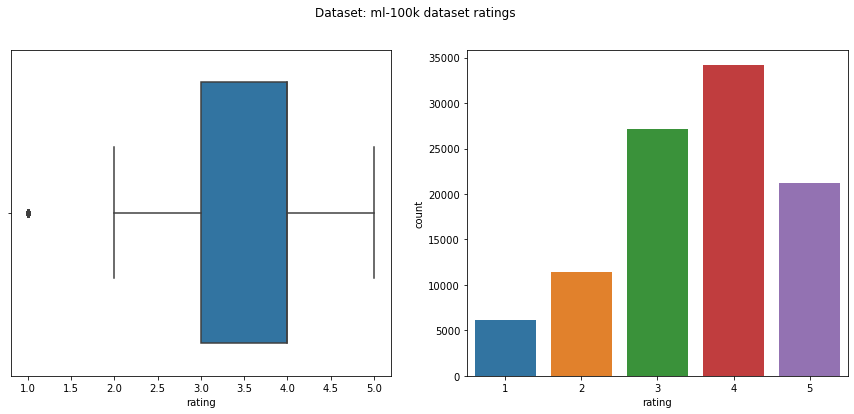

In [15]:
f, axes = plt.subplots(1, 2,figsize=(15,6))
sns.boxplot(df_ratings.rating,ax=axes[0])
sns.countplot(df_ratings.rating,ax=axes[1])
plt.suptitle('Dataset: {} dataset ratings'.format(dataset_name))
plt.show()

Distribution of number of ratings per user and items

Text(0.5, 0.98, 'Dataset: ml-100k distribution of ratings per user and item')

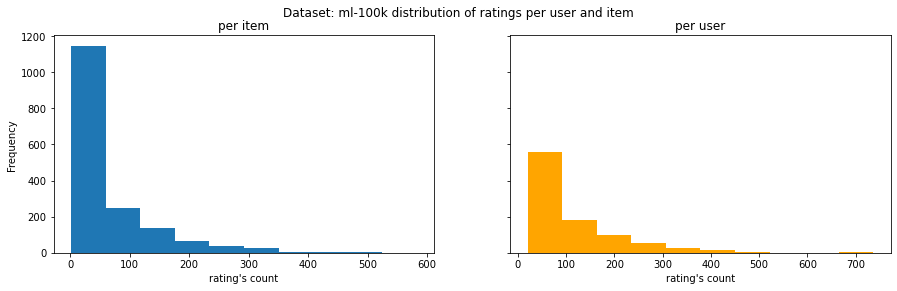

In [16]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15, 4))

ratings.astype(bool).sum(axis=0).plot.hist(ax=ax[0])
ratings.astype(bool).sum(axis=1).plot.hist(ax=ax[1],color='orange')
ax[0].set_title('per item')
ax[1].set_title('per user')
ax[0].set_xlabel('rating\'s count')
ax[1].set_xlabel('rating\'s count');
plt.suptitle('Dataset: {} distribution of ratings per user and item'.format(dataset_name))


# Baseline Model Implementation & Evaluation 

In this section we reproduce the results from the original paper


In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


## Baseline algorithm - Matrix Factorization Neural Network

In [18]:
class MF_NN(nn.Module):
    def __init__(self, max_user_id, max_item_id,latent_dim_mf):
        super(MF_NN , self).__init__()

        self.embedding_user_mf = Embedding(num_embeddings=max_user_id, embedding_dim=latent_dim_mf)
        self.embedding_item_mf = Embedding(num_embeddings=max_item_id, embedding_dim=latent_dim_mf)
    
    def forward(self, user_indices, item_indices):
        
        user_embedding_mf = self.embedding_user_mf(user_indices)
        item_embedding_mf = self.embedding_item_mf(item_indices)
    
        mf_vector =torch.mul(user_embedding_mf, item_embedding_mf)
        mf_result = mf_vector.sum(dim = 1)  # dim 0 is the batch 
        
        return mf_result
    
    def num_params(self):
       return sum(p.numel() for p in self.parameters() if p.requires_grad)

## Original "AutoRec" Architechture Model

In [19]:
class AutoRec(nn.Module):
    def __init__(self, input_dim , hidden_dims = [500], dropout = 0,activation=Sigmoid(),bn=False): # Must have at least 1 hidden layer
        super(AutoRec , self).__init__()
       
        layers = []
        #checking odd number of layers
        assert(len(hidden_dims)%2==1)
        middle_layer=int(len(hidden_dims)/2)+1
        # Linear  Hidden Layers 
        for layer_num  in range(len(hidden_dims)):
            if layer_num == 0:
                num_in_channels = input_dim
            else:
                num_in_channels = hidden_dims[layer_num - 1]
            linear1 = Linear(num_in_channels, hidden_dims[layer_num])
            layers.append(linear1)
            # nn.init.normal_(linear1.weight, 0, 0.03)
            # nn.init.xavier_normal_(linear1.weight)
            layers.append(activation)   # Activation Layer
            #Add Dropout after the layent space - after last encoder layer (or first decoder layer)
            if (bn==True):
              layers.append(nn.BatchNorm1d(hidden_dims[layer_num]))
            if (layer_num==middle_layer-1) & (dropout>0):           
              layers.append(nn.Dropout(dropout))
       
        # Last linear  
        linear2 = Linear(hidden_dims[layer_num], input_dim)
        layers.append(linear2)
        # nn.init.xavier_normal_(linear2.weight)
        # nn.init.normal_(linear2.weight, 0, 0.03)
        #Trying to add Identity as in the paper
        layers.append(Identity())

        self.autorec_sequential = nn.Sequential(*layers)
    
    def forward(self, vect):
        
        autorec_result = self.autorec_sequential(vect)  #.squeeze()     

        return autorec_result
    
    def num_params(self):
       return sum(p.numel() for p in self.parameters() if p.requires_grad)

## Training

**Loading the 5 folds of the dataset**

In [20]:
# %%time

def add_skip_col (df): 
    indx = 1
    for col in df.columns:
        while (indx < col):
            df.insert(indx-1, indx, np.zeros(df.shape[0])) 
            indx = indx + 1
        indx +=1
    return df

def add_skip_row (df): 
    indx = 1
    for row in df.index:
        while (indx < row):
            df.loc[indx+0.5] = np.zeros(test_df.shape[1]) 
            df = df.sort_index().reset_index(drop = True)  # Reset index
        indx = indx + 1     
    indx +=1
    
df_folds = {i:
       {'train' : pd.read_csv('{}u{}.base'.format(data_dir,i), delimiter=folds_delim, header=None, names=cols_data).drop_duplicates(),
        'test'  : pd.read_csv('{}u{}.test'.format(data_dir,i), delimiter=folds_delim, header=None, names=cols_data).drop_duplicates()
       } for i in range(1,6)} 

def fold2df(i):
    train = df_folds[i]['train'].pivot(index = 'user_id', columns ='item_id', values = 'rating').fillna(0)
    test  = df_folds[i]['test'].pivot(index = 'user_id', columns ='item_id', values = 'rating').fillna(0)
    return train,test 

def getfulldf(train_fold,test_fold):
    train = ratings.copy()
    train[:] = 0
    test = train.copy() 
    train.loc[train_fold.index,train_fold.columns] = train_fold.values
    test.loc[test_fold.index,test_fold.columns] = test_fold.values
    train = add_skip_col(train)
    test = add_skip_col(test)
    return train,test

fold = 2
train,test = getfulldf(*fold2df(fold))

print(train.shape,test.shape)

(943, 1682) (943, 1682)


In [21]:
df_ratings_train = df_folds[fold]['train'].drop(['timestamp'], axis = 1)
df_ratings_test  = df_folds[fold]['test'].drop(['timestamp'], axis = 1)

In [22]:
max_user_id     = df_ratings_train['user_id'].max()+1
max_item_id     = df_ratings_train['item_id'].max()+1

max_user_id , max_item_id

(944, 1683)

**MF Data loader**

In [23]:
# MF
batch_size_mf    = 512

train_samples    = torch.tensor(df_ratings_train[['user_id' , 'item_id']].values)
train_labels     = torch.tensor(df_ratings_train[ 'rating'].values)
ds_train_mf      = torch.utils.data.TensorDataset(train_samples, train_labels)
dl_train_mf      = DataLoader(ds_train_mf,batch_size=batch_size_mf,shuffle=True)

test_samples     = torch.tensor(df_ratings_test[['user_id' , 'item_id']].values)
test_labels      = torch.tensor(df_ratings_test[ 'rating'].values)
ds_test_mf       = torch.utils.data.TensorDataset(test_samples, test_labels)
dl_test_mf       = DataLoader(ds_test_mf,batch_size=1024,shuffle=False)

**AutoRec Data loader**

In [24]:
# AutoRec
#every row of a user with its rating
def create_autorec_dataloader(batch_size=128):
  train_samples_users    = torch.tensor(train.values)
  train_samples_items    = torch.tensor(train.T.values)
  ds_train_users         = torch.utils.data.TensorDataset(train_samples_users,torch.ones(train.shape[0]))
  ds_train_items         = torch.utils.data.TensorDataset(train_samples_items,torch.ones(train.shape[1]))

  test_samples_users    = torch.tensor(test.values)
  test_samples_items    = torch.tensor(test.T.values)
  ds_test_users         = torch.utils.data.TensorDataset(test_samples_users,torch.ones(test.shape[0]))
  ds_test_items         = torch.utils.data.TensorDataset(test_samples_items,torch.ones(test.shape[1]))
  dl_train_users        = DataLoader(ds_train_users,batch_size=batch_size,shuffle=True)
  dl_train_items        = DataLoader(ds_train_items,batch_size=batch_size,shuffle=True)
  dl_test_users         = DataLoader(ds_test_users,batch_size=1024,shuffle=False) # not used 
  dl_test_items         = DataLoader(ds_test_items,batch_size=1024,shuffle=False) # not used 

  return dl_train_users,dl_train_items,ds_test_users,dl_test_items

**Classes for traning the models**

In [25]:
# Class for training and ploting the results 
class Runner:
    def __init__(self):
        self.loss_train_arr  = []
        self.loss_test_arr   = []
    
    def train_network(self, optimizer, criterion ,  dl_train ,dl_test  \
                         , num_epoch = 50 , early_stopping = 5,verbose=False,
                      scheduler=None):
        start_time = timer()
                
        epochs_without_improvement = 0
        best_test_loss             = None 
            
        for epoch in range(num_epoch):         
            # Train loop
            train_loss = self.epoch_func_train(dl_train,optimizer, criterion)
            self.loss_train_arr.append(train_loss)
            
            # Test  evaluation
            test_loss = self.epoch_func_test(dl_test,criterion)
            self.loss_test_arr.append(test_loss)
            
            # Early Stop and best model save 
            if not best_test_loss or test_loss < best_test_loss:   
                best_train_loss = train_loss
                best_test_loss  = test_loss
                epochs_without_improvement = 0
                #print ("Achieved lower test loss  , save model  at epoch number {} ".format(epoch + 1) )
                best_state_dict = copy.deepcopy(self.model.state_dict())
            else:
                epochs_without_improvement += 1

            if epochs_without_improvement == early_stopping:
                print ("Early stoping after {} epochs. Test loss did not imporve for more than {} epcochs".format(epoch,early_stopping))
                # pass #?
                break
            
            # Verbose
            if (verbose) & (epoch % int(   max(1,num_epoch/10)   ) == 0):   #  report every 10% of the number of epoch
            #if (1):   #  report every 10% of the number of epochs
                print("Epoch {epoch_id}".format(epoch_id=epoch + 1),end=',')
                print("Train loss  : {:.3f}".format(train_loss),end=',')
                print("Test loss    : {:.3f}".format(test_loss))
            
            if scheduler!=None:
              scheduler.step(test_loss)
        
        # Finish  training 
        self.model.load_state_dict(best_state_dict)
        if (verbose):
          print('\nFinished Training, Train loss={:.3f}, Test loss={:.3f}'.format(best_train_loss ,best_test_loss ))
  
        end_time      = timer()
        self.fit_time = end_time - start_time
        return best_train_loss ,best_test_loss
        
    def loss_graph(self):
        fig, ax = plt.subplots(1, 1,figsize=(10, 4))
        ax.set_title('Loss vs Epoch')
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')
        ax.set_yscale('log')
        ax.plot(self.loss_train_arr, label="Train loss")
        ax.plot(self.loss_test_arr, label="Test loss")
        ax.legend()


In [26]:
class Runner_MF(Runner):
    
    def __init__(self , model , device):
        super().__init__()
        self.model  = model
        self.device = device
        
    def epoch_func_train(self , dl_train , optimizer, criterion,verbose=False):
        num_batches_train = len(dl_train)
        train_loss        = 0
        for batch  in tqdm(dl_train, disable=(not verbose)):
            user_item , label = batch
            user   = user_item[:,0]
            item   = user_item[:,1]        
            # Send tensors to GPU
            user   = user.to(self.device)
            item   = item.to(self.device)
            label  = label.to(self.device).type(torch.float32)
                 
            pred   = self.model(user , item)
            loss   = criterion(pred , label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()               
            train_loss += loss.item()
        
        train_loss = train_loss / num_batches_train
        return train_loss
    
    def epoch_func_test(self , dl_test ,criterion):     
        num_batches_test = len(dl_test)
        test_loss        = 0
        for batch  in dl_test:
            user_item , label = batch
            user   = user_item[:,0]
            item   = user_item[:,1]        
            # Send tensors to GPU
            user  = user.to(self.device)
            item  = item.to(self.device)
            label = label.to(self.device).type(torch.float32)
            with torch.no_grad():     
                pred   = self.model(user , item)
                loss   = criterion(pred , label)
            test_loss += loss.item()
        
        test_loss = test_loss / num_batches_test
        return test_loss
      
    def predict_all(self , max_user_id , max_item_id): 
        size = 500 # Break due to memory issues 
        predictions = torch.ones((max_user_id-1 , max_item_id-1))  
        for user_id in range(1 , max_user_id):
            user_vector = torch.full( (size,), user_id).to(self.device)
            for item_id in range(1 , max_item_id , size): # limit to 100 due to GPU memory 
                last_item_id = min(item_id+size , max_item_id)
                item_vector = torch.arange(item_id,last_item_id).to(self.device)
                vect_size = last_item_id-item_id
                if vect_size < size:
                    user_vector = torch.full( (vect_size,), user_id).to(self.device)  
                with torch.no_grad():  
                    pred_user = self.model(user_vector , item_vector)
                predictions[user_id-1 , item_id-1:last_item_id-1] = pred_user
                del item_vector 
                torch.cuda.empty_cache()   # free memory
            del user_vector
        return predictions

In [27]:
class Runner_AutoRec(Runner):
    
    def __init__(self , model , train , test , device, content_gain = 1 , content_cols = 0 ):
        super().__init__()
        self.model  = model
        self.device = device
        self.train  = torch.tensor(train).to(self.device).type(torch.float32)
        self.test   = torch.tensor(test).to(self.device).type(torch.float32)
        self.content_gain  = content_gain
        self.content_cols  = content_cols
    
        
    def epoch_func_train(self , dl_train , optimizer, criterion,verbose=False):
        num_batches_train = len(dl_train)
        train_loss        = 0
        for  batch  in tqdm(dl_train,disable=(not verbose)):
            vector ,_ = batch  
            # Send tensors to GPU
            vector = vector.to(self.device).type(torch.float32)
            pred   = self.model(vector)
            
            vector_rating      = vector[:,0:vector.shape[1]-self.content_cols]
            non_zero_ratings   = torch.count_nonzero(vector_rating).item()
            content_size       = self.content_cols*vector.shape[0]
            alpha              = non_zero_ratings / (non_zero_ratings + content_size)
            
            loss   = criterion(pred[:,0:pred.shape[1]-self.content_cols] , vector[:,0:vector.shape[1]-self.content_cols])*alpha + \
                     criterion(pred[:,-self.content_cols:] , vector[:,-self.content_cols:])*(1-alpha)*self.content_gain #content gain cols        
            
          #  alpha = (pred.shape[1]-self.content_cols) / pred.shape[1]
          #  beta  = self.content_cols / pred.shape[1]
          #  loss   = criterion(pred[:,0:pred.shape[1]-self.content_cols] , vector[:,0:vector.shape[1]-self.content_cols])*alpha + \
          #           criterion(pred[:,-self.content_cols:] , vector[:,-self.content_cols:])*beta*self.content_gain #content gain cols        
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()               
            train_loss += loss.item()
               
        train_loss = train_loss / num_batches_train
        return train_loss
    
    def epoch_func_test(self , dl_test,criterion):
        with torch.no_grad():
            pred      = self.predict_all(self.train)
            test_loss = criterion(pred , self.test)        
        return test_loss.item()
        
    def predict_all(self , ratings): 
        ratings_t = torch.tensor(ratings).to(self.device).type(torch.float32)
        predictions = self.model(ratings_t)
        return predictions

## Metrics For Evaluation

In [28]:
class my_metrics():
    
    def clean_data(df_true,df_pred,lower_bound,upper_bound):   # All inputs are  numpy
        
        # zero the values  of both true and prediction for non valid ground true
        # df_pred never has zeros or nulls, as it is requested to predict on every cell       
        assert(df_true.shape==df_pred.shape,'true shape:{} and pred shape:{}, dataframes shapes are different'.format(df_true.shape,df_pred.shape))
        
        idx_ignore           = np.where( (df_true < lower_bound) |  (df_true > upper_bound ) ) 
        number_valid_ratings = df_true.size   - len(idx_ignore[0]) 
        true_values          = np.copy(df_true)
        true_values[idx_ignore]  = 0 # will not add to the  score 
        pred_values              = np.copy(df_pred)
        pred_values[idx_ignore]  = 0 # will not add to the  score 
              
        return true_values , pred_values , number_valid_ratings 
        
    def RMSE(df_true,df_pred,lower_bound=1,upper_bound=5):
        
        true_values , pred_values , number_valid_ratings = my_metrics.clean_data(df_true,df_pred,lower_bound,upper_bound)
                
        return ( ((true_values - pred_values)**2).sum() /(number_valid_ratings))**0.5
          
    def MRR(df_true,df_pred,lower_bound=1,upper_bound=5,top_n=5,relevancy_threshold=3):
        # please use MRR_for_user
        # ignore in the prediction  for  non valid ratings 
        true_values , pred_values , number_valid_ratings = my_metrics.clean_data(df_true,df_pred,lower_bound,upper_bound)    
        num_of_users = df_true.shape[0]
        mrr_sum = 0
        for user_id in range(num_of_users):
            
            mrr , reduce_user = my_metrics.MRR_for_user(true_values[user_id,:],pred_values[user_id,:],\
                                               lower_bound,upper_bound,top_n,relevancy_threshold)
            
            mrr_sum += mrr
            num_of_users -= reduce_user
           
        return  mrr_sum/num_of_users
    
    def MRR_for_user(user_true,user_pred,lower_bound,upper_bound,top_n,relevancy_threshold):

        relevant_vector   = (user_true >=relevancy_threshold)*1
        if (relevant_vector.sum() == 0):
            reduce_user = 1
            mrr         = 0
        else:
            reduce_user = 0
            # extract top n prediction 
            pred_top_n_items  = (-user_pred).argsort()[0:top_n]
            # check the top_n in the relevant vector 
            relevant_vector_top_n = relevant_vector[pred_top_n_items]
        
            # Find the first relevant  index
            relevant_idx = np.nonzero(relevant_vector_top_n)
        
            if len(relevant_idx[0]) ==  0:
                mrr = 0
            else:
                mrr =  1/(relevant_idx[0][0]+1)
           
        return mrr , reduce_user
    
    def NDCG(df_true,df_pred,lower_bound=1,upper_bound=5,top_n=5):
        # please use NDCG_for_user
        
        # ignore in the score the ground true that has non valid ratings 
        true_values , pred_values , number_valid_ratings = my_metrics.clean_data(df_true,df_pred,lower_bound,upper_bound)            
        num_of_users = df_true.shape[0]
        
        nDCG_sum = 0
        for user_id in range(num_of_users):
            nDCG , reduce_user = my_metrics.NDCG_for_user(true_values[user_id,:],pred_values[user_id,:],lower_bound,upper_bound,top_n)
            nDCG_sum += nDCG
            num_of_users -= reduce_user
        
        return  nDCG_sum/num_of_users
        
    def NDCG_for_user(user_true,user_pred,lower_bound,upper_bound,top_n):
        # please use DCG function
        
        reduce_user       = (np.count_nonzero(user_true) == 0)*1    
        
        pred_sort         = (-user_pred).argsort()
        relevant_vector   = user_true[pred_sort][0:top_n]
        
        # DCG
        DCG_score         = my_metrics.DCG(relevant_vector , top_n)
        
        #IDCG
        relevant_vector_ideal = np.sort(relevant_vector)[::-1] # max to min 
        IDCG_score            = my_metrics.DCG(relevant_vector_ideal , top_n)
        
        if (IDCG_score == 0):
            return 0 , reduce_user
        else: 
            return DCG_score/IDCG_score , reduce_user
    
    def DCG(rel,n):
        # please implement the DCG formula

        decay_vector  =   np.log2(np.arange(start = 1 , stop = n+1 , step = 1) +1 )
        return        ((rel/decay_vector)).sum()
       
    def get_error(df_true,df_pred):        
        return {'RMSE':my_metrics.RMSE(df_true,df_pred,),'MRR_5':my_metrics.MRR(df_true,df_pred,top_n=5),'MRR_10':my_metrics.MRR(df_true,df_pred,top_n=10),'NDCG_5':my_metrics.NDCG(df_true,df_pred,top_n=5),'NDCG_10':my_metrics.NDCG(df_true,df_pred,top_n=10)}


In [29]:
def autorec_mse_loss (pred , label):  # receives Tensors 
    # Zero all pred where label is also zero (no ratings available)
    zero_indx = (label == 0)
    cnt_nonzero = torch.count_nonzero(label).item()
    pred[zero_indx] = 0
    cnt_nonzero = max(1,cnt_nonzero)  # sometimes no ratings
    return  ( ((pred - label)**2).sum() / cnt_nonzero ) 

In [30]:
final_results = pd.DataFrame(columns=['Method','RMSE','MRR_5','MRR_10','NDCG_5','NDCG_10','Time','Params'])

def model_eval (name , runner , test,pred ,save_results = True):
    rmse   = round(my_metrics.RMSE(test ,pred)   , 3)
    mrr10  = round(my_metrics.MRR(test,pred,top_n=10 , relevancy_threshold=3)  , 3)
    mrr5   = round(my_metrics.MRR(test,pred,top_n=5 , relevancy_threshold=3) , 3) 
    ndcg10 = round(my_metrics.NDCG(test,pred,top_n=10) , 3)
    ndcg5  = round(my_metrics.NDCG(test,pred,top_n=5) , 3)
    time   = runner.fit_time
    params = runner.model.num_params()
    
    if (save_results == True):
        final_results.loc[len(final_results)] = name , rmse, mrr10 , mrr5 , ndcg10, ndcg5 , time , params
    
    return name , rmse, mrr10 , mrr5 , ndcg10, ndcg5 , time , params

In [31]:
def init_param(model):
    for param in model.named_parameters():
      param[1].data.normal_(0.0 ,0.03)
        # param[1].data.normal_(0.0 ,0.01)

## Training the Baseline MF

MF_NN(
  (embedding_user_mf): Embedding(944, 20)
  (embedding_item_mf): Embedding(1683, 20)
) 

Model parameters: 52540
Epoch 1,Train loss  : 13.676,Test loss    : 13.684
Epoch 6,Train loss  : 1.180,Test loss    : 1.185
Epoch 11,Train loss  : 0.893,Test loss    : 0.947
Epoch 16,Train loss  : 0.858,Test loss    : 0.917
Epoch 21,Train loss  : 0.845,Test loss    : 0.909
Epoch 26,Train loss  : 0.835,Test loss    : 0.903
Epoch 31,Train loss  : 0.819,Test loss    : 0.896
Epoch 36,Train loss  : 0.792,Test loss    : 0.885
Epoch 41,Train loss  : 0.758,Test loss    : 0.873
Epoch 46,Train loss  : 0.719,Test loss    : 0.863

Finished Training, Train loss=0.684, Test loss=0.857
Wall time: 55.7 s


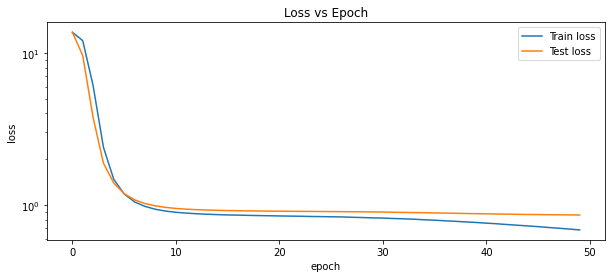

In [32]:
%%time

def train_mf_nn(latent_dim=20,lr=1e-3,epochs=10,verbose=False):
  mf_criterion  = nn.MSELoss() 
  #Re-using the same hyper paramter of "hidden_dims" for the latent space dim 
  mf_model      = MF_NN(max_user_id, max_item_id,latent_dim_mf=latent_dim).to(device)  

  init_param(mf_model)  # for normal dist
  num_params = mf_model.num_params()
  if verbose:
    print(mf_model,"\n")
    print('Model parameters:',num_params)
  mf_optim  = Adam(mf_model.parameters(), lr=lr) 
        
  runner_mf = Runner_MF(mf_model,device)  
  train_loss,val_loss = runner_mf.train_network(mf_optim, mf_criterion , dl_train_mf ,
                                                dl_test_mf, num_epoch = epochs , early_stopping = 5,verbose=verbose)
  return runner_mf,train_loss,val_loss

def evaluate_mf_nn(runner_mf, model_name = 'MF_NN'):
  # Evaluation
  pred   = runner_mf.predict_all(max_user_id , max_item_id).detach().cpu().numpy()
  return model_eval(model_name , runner_mf , test.values,pred)

#TODO UNCOMMENT for plotting
runner_mf,_,_ = train_mf_nn(epochs=50,verbose=True)
evaluate_mf_nn(runner_mf)

runner_mf.loss_graph()


In [33]:
final_results

,Method,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10,Time,Params
0,MF_NN,0.925,0.977,0.977,0.959,0.964,51.742356,52540


## AutoRec User - Reporduing the RMSE results from the paper

AutoRec(
  (autorec_sequential): Sequential(
    (0): Linear(in_features=1682, out_features=100, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=100, out_features=1682, bias=True)
    (3): Identity()
  )
) 

Model parameters: 338182
Epoch 1,Train loss  : 13.844,Test loss    : 12.688
Epoch 51,Train loss  : 1.011,Test loss    : 1.085
Epoch 101,Train loss  : 0.975,Test loss    : 1.057
Epoch 151,Train loss  : 0.947,Test loss    : 1.037
Epoch 201,Train loss  : 0.891,Test loss    : 0.997
Epoch 251,Train loss  : 0.830,Test loss    : 0.960
Epoch 301,Train loss  : 0.780,Test loss    : 0.935
Epoch 351,Train loss  : 0.735,Test loss    : 0.914
Epoch 401,Train loss  : 0.693,Test loss    : 0.897
Epoch 451,Train loss  : 0.651,Test loss    : 0.888

Finished Training, Train loss=0.613, Test loss=0.886
('AutoRec_User', 0.941, 0.974, 0.974, 0.958, 0.963, 25.838136000000006, 338182)
Wall time: 26.5 s


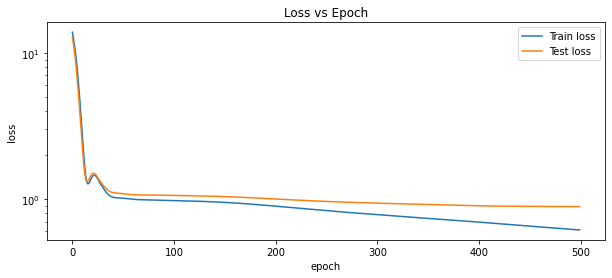

In [34]:
%%time

'''
AutoRec User - Best Test RMSE=0.876
Hyperparameters used: {'Iterations': 500, 'Hid_dim_size': 100, 'Learning_Rate': 0.003, 'Dropout': 0, 'Batch_size': 1024
'''

def train_autorec_user(hidden_dims=[100],lr=0.003,epochs=500,dropout=0,batch_size=1024,verbose=False,activation=Sigmoid(),optimizer='adam'):
  autorec_user_criterion  = autorec_mse_loss

  autorec_user_model      = AutoRec(input_dim = train.shape[1],hidden_dims = hidden_dims,dropout=dropout,activation=activation).to(device) 

  # init_param(autorec_user_model)  # for normal dist
  num_params = autorec_user_model.num_params()
  if verbose:          
    print(autorec_user_model,"\n")
    print('Model parameters:',num_params)
  
  if optimizer=='adam':
    autorec_user_optim  = Adam(autorec_user_model.parameters(), lr=lr,weight_decay=2*1e-4) 
  else:
    print('SGD')
    autorec_user_optim  = SGD(autorec_user_model.parameters(), lr=lr,weight_decay=2*1e-4,momentum=0.9) 
  scheduler = lr_scheduler.ReduceLROnPlateau(autorec_user_optim, mode='min', 
                                             factor=0.7, patience=10,min_lr=0.0001, verbose=False)
  
  #create the data loader
  dl_train_users ,dl_test_users,_,_ = create_autorec_dataloader(batch_size)
  
  runner_autorec_user = Runner_AutoRec(autorec_user_model, train.values , test.values , device)
  train_loss,val_loss = runner_autorec_user.train_network(autorec_user_optim, autorec_user_criterion , dl_train_users ,dl_test_users, \
                                  num_epoch = epochs , early_stopping = 30,verbose=verbose,scheduler=scheduler)

  return runner_autorec_user,train_loss,val_loss

def evaluate_autorec_user(runner_autorec_user,save_results , model_name = 'AutoRec_User'):
  # Evaluation
  pred = runner_autorec_user.predict_all(train.values).detach().cpu().numpy()
  return model_eval (model_name , runner_autorec_user , test.values,pred,save_results)

#TODO UNCOMMENT for plotting
runner_autorec_user,_,_ = train_autorec_user(verbose=True)
print(evaluate_autorec_user(runner_autorec_user,save_results = True))

runner_autorec_user.loss_graph()

In [35]:
final_results.groupby('Method').min('RMSE')

,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10,Time
Method,,,,,,
AutoRec_User,0.941,0.974,0.974,0.958,0.963,25.838136
MF_NN,0.925,0.977,0.977,0.959,0.964,51.742356


## AutoRec Item - Reporduing the RMSE results from the paper

AutoRec(
  (autorec_sequential): Sequential(
    (0): Linear(in_features=943, out_features=400, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=400, out_features=943, bias=True)
    (3): Identity()
  )
) 

Model parameters: 755743
Epoch 1,Train loss  : 11.581,Test loss    : 5.616
Epoch 51,Train loss  : 0.683,Test loss    : 0.827
Epoch 101,Train loss  : 0.449,Test loss    : 0.802
Early stoping after 118 epochs. Test loss did not imporve for more than 30 epcochs

Finished Training, Train loss=0.497, Test loss=0.800
('AutoRec_Item', 0.894, 0.967, 0.967, 0.967, 0.971, 6.616138200000009, 755743)
Wall time: 7.24 s


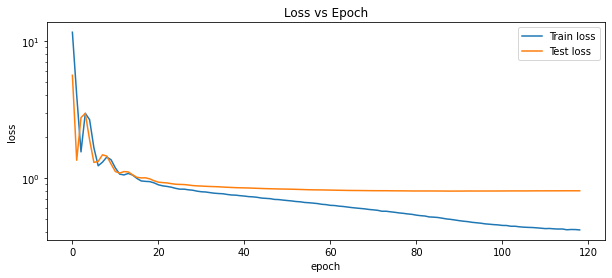

In [36]:
%%time

'''
Best Test RMSE=0.839, was obtained by config=2
BEST: 0.839.... def train_autorec_item(hidden_dims=[400],lr=0.003,epochs=500,dropout=0,batch_size=1024,verbose=False,activation=Sigmoid()):

'''

def train_autorec_item(hidden_dims=[400],lr=0.003,epochs=500,dropout=0,batch_size=1024,
                       verbose=False,activation=Sigmoid(),optimizer='adam',wd=2*1e-4):

  autorec_item_criterion  = autorec_mse_loss
  autorec_item_model      = AutoRec(input_dim = max_user_id-1,hidden_dims = hidden_dims,dropout=dropout,activation=activation).to(device) 

  # init_param(autorec_item_model)  # for normal dist
  num_params = autorec_item_model.num_params()
  
  if verbose:
    print(autorec_item_model,"\n")
    print('Model parameters:',num_params)

  if optimizer=='adam':
    autorec_item_optim  = Adam(autorec_item_model.parameters(), lr=lr,weight_decay=wd) 
  else:
    print('SGD')
    autorec_item_optim  = SGD(autorec_item_model.parameters(), lr=lr,weight_decay=wd,momentum=0.9) 

  # autorec_item_optim  = Adam(autorec_item_model.parameters(), lr=lr,weight_decay=wd) 
  scheduler = lr_scheduler.ReduceLROnPlateau(autorec_item_optim, mode='min', 
                                             factor=0.8, patience=3, verbose=False)

  #create the data loader
  _,dl_train_items,_,dl_test_items = create_autorec_dataloader(batch_size)
  
  runner_autorec_item = Runner_AutoRec(autorec_item_model, train.values.T , test.values.T , device)  
  train_loss,val_loss = runner_autorec_item.train_network(autorec_item_optim, autorec_item_criterion ,
                                                          dl_train_items ,dl_test_items, 
                                                          num_epoch = epochs , early_stopping = 30,verbose=verbose,
                                                          scheduler=scheduler)
  return runner_autorec_item,train_loss,val_loss

def evaluate_autorec_item(runner_autorec_item, save_results , model_name = 'AutoRec_Item'):
  # Evaluation
  pred = runner_autorec_item.predict_all(train.values.T).detach().cpu().numpy()
  return model_eval (model_name , runner_autorec_item , test.values.T,pred,save_results)

#TODO UNCOMMENT for plotting
runner_autorec_item,_,_ = train_autorec_item(verbose=True)

print(evaluate_autorec_item(runner_autorec_item,save_results = True))

runner_autorec_item.loss_graph()


In [37]:
final_results

,Method,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10,Time,Params
0,MF_NN,0.925,0.977,0.977,0.959,0.964,51.742356,52540
1,AutoRec_User,0.941,0.974,0.974,0.958,0.963,25.838136,338182
2,AutoRec_Item,0.894,0.967,0.967,0.967,0.971,6.616138,755743


In [38]:
#final_results.groupby('Method').min('RMSE')

In [39]:
rmse0=final_results.groupby('Method').min('RMSE')['RMSE']
print('Diff from paper results RMSE Item:{:.4f}'.format(rmse0[0]-0.831))
print('Diff from paper results RMSE User:{:.4f}'.format(rmse0[1]-0.874))

Diff from paper results RMSE Item:0.0630
Diff from paper results RMSE User:0.0670


## Reproduced paper results

To reproduce the results we used the suggested basic AutoEncoder architechture with a single linear layer + Sigmoid for the Encoder, and a single linear layer for the Decoder.
We experimented with various hidden layers sizes, and searched for the best hyper parameters by using 5-Fold Cross Validation, using permutations of the following hyper parameters:

For *AutoRec User* best Test RMSE=0.876 (**bold** indicated the selected values):
Hyperparameters used:

1. Hidden Layer size=[32,64,**100**,128,250,500]
2. Learning rate = [0.1,0.01,0.001,**0.003**,0.0001,0.0003,0.00001]
3. Batch size = [16,32,128,512,**1024**]
4. Activation = [**Sigmoid**,ReLU,Tanh]

For *AutoRec Item* best Test RMSE=0.839 (**bold** indicated the selected values):

1. Hidden Layer size=[32,64,**100**,128,250,**400**,500]
2. Learning rate = [0.1,0.01,0.001,**0.003**,0.0001,0.0003,0.00001]
3. Batch size = [16,32,128,512,**1024**]
4. Activation = [**Sigmoid**,ReLU,Tanh]


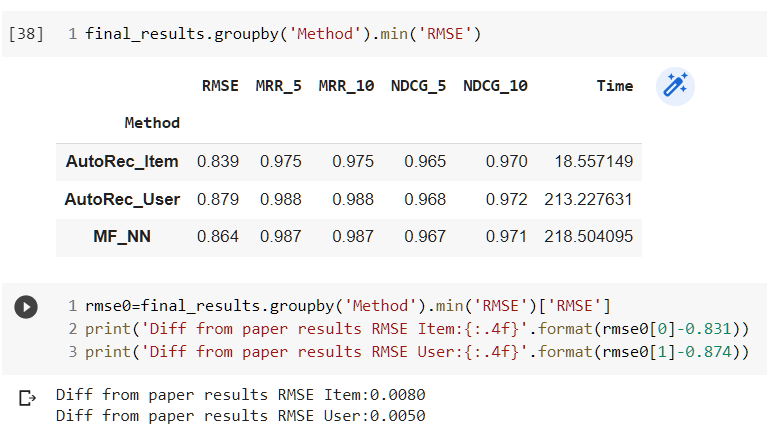

**Results Summary**

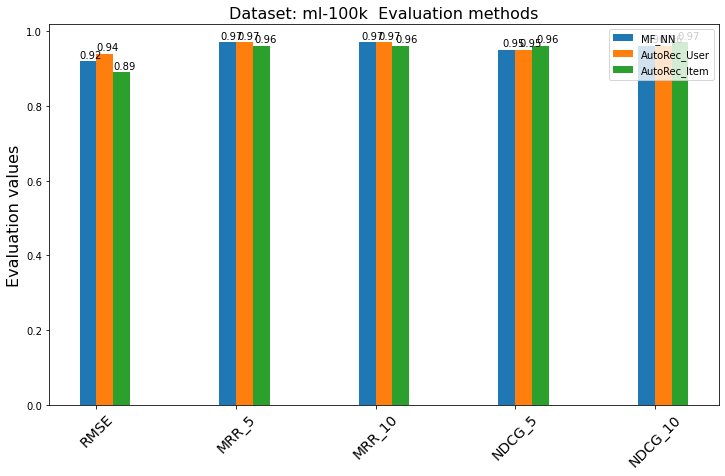

In [40]:
labels = ["RMSE" , "MRR_5" , "MRR_10", "NDCG_5" ,"NDCG_10"]
x = np.arange(len(labels))


MF_NN = [final_results.loc[0,'RMSE'] , \
        final_results.loc[0,'MRR_5'] , \
        final_results.loc[0,'MRR_10'] , \
        final_results.loc[0,'NDCG_5'] , \
        final_results.loc[0,'NDCG_10']]

AutoRec_User = [final_results.loc[1,'RMSE'] , \
            final_results.loc[1,'MRR_5'] , \
            final_results.loc[1,'MRR_10'] , \
            final_results.loc[1,'NDCG_5'] , \
            final_results.loc[1,'NDCG_10']]

AutoRec_Item = [final_results.loc[2,'RMSE'] , \
            final_results.loc[2,'MRR_5'] , \
            final_results.loc[2,'MRR_10'] , \
            final_results.loc[2,'NDCG_5'] , \
            final_results.loc[2,'NDCG_10']]
        

MF_NN           = [ int(i*100)/100  for i in MF_NN]
AutoRec_User    = [ int(i*100)/100  for i in AutoRec_User]
AutoRec_Item    = [ int(i*100)/100  for i in AutoRec_Item]


fig, ax = plt.subplots(1, 1, figsize=(12, 7))
width = 0.12
ax.bar(x - width/2, MF_NN , width, label='MF_NN')
ax.bar(x + width/2, AutoRec_User , width, label='AutoRec_User')
ax.bar(x + (3/2)*width, AutoRec_Item, width, label='AutoRec_Item')
ax.set_title("Dataset: {}  Evaluation methods".format(dataset_name), fontsize=16)
ax.set_ylabel("Evaluation values", fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels ,fontsize=14,rotation=45)
ax.legend()

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.010, p.get_height() * 1.010))



<br>

## RMSE Vs Latent Dim Size (Single Layer AutoEncoder)

<br>

In [41]:
'''
A dictionary holding the names of the model functions to call dynamically during the KFold CV
'''
models = {'MF_NN': {'model_train_func':'train_mf_nn','model_eval_func':'evaluate_mf_nn'},
          'AutoRec_User': {'model_train_func':'train_autorec_user','model_eval_func':'evaluate_autorec_user'},
          'AutoRec_Item':{'model_train_func':'train_autorec_item','model_eval_func':'evaluate_autorec_item'}
          }



latent dim = 30
AutoRec_User RMSE: 1.031
AutoRec_Item RMSE: 0.919

latent dim = 50
AutoRec_User RMSE: 0.945
Early stoping after 436 epochs. Test loss did not imporve for more than 30 epcochs
AutoRec_Item RMSE: 0.912

latent dim = 100
AutoRec_User RMSE: 0.961
Early stoping after 260 epochs. Test loss did not imporve for more than 30 epcochs
AutoRec_Item RMSE: 0.9

latent dim = 150
Early stoping after 453 epochs. Test loss did not imporve for more than 30 epcochs
AutoRec_User RMSE: 0.942
Early stoping after 194 epochs. Test loss did not imporve for more than 30 epcochs
AutoRec_Item RMSE: 0.899

latent dim = 200
Early stoping after 322 epochs. Test loss did not imporve for more than 30 epcochs
AutoRec_User RMSE: 0.947
Early stoping after 205 epochs. Test loss did not imporve for more than 30 epcochs
AutoRec_Item RMSE: 0.899

latent dim = 300
Early stoping after 280 epochs. Test loss did not imporve for more than 30 epcochs
AutoRec_User RMSE: 0.943
Early stoping after 144 epochs. Test los

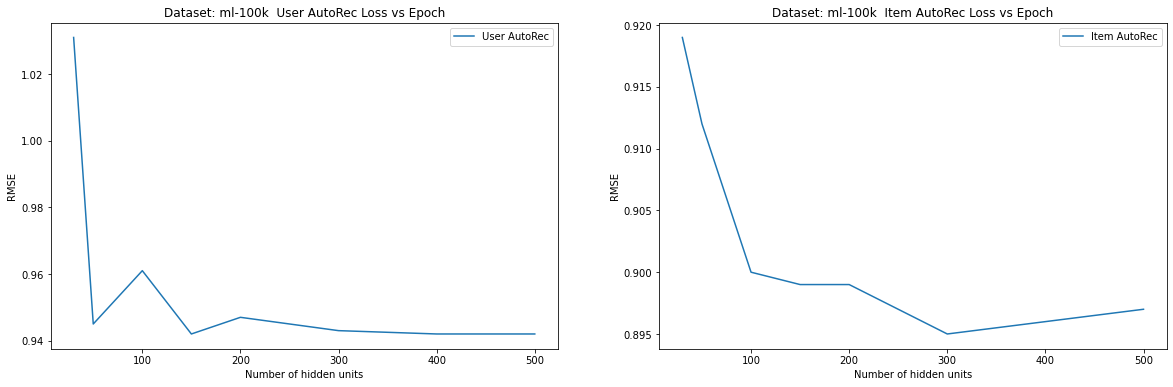

In [42]:
def plot_rmse_vs_latent_dim():
    latent_dim = [30, 50 ,100 , 150 , 200 , 300 ,  400, 500]
    
    AutoRec_User_list = []
    AutoRec_Item_list = [] 
    
    for dim_size  in latent_dim:
        print ("\nlatent dim = {}".format(dim_size))
        for model_name in ["AutoRec_User" , "AutoRec_Item"]:
            trn_f = globals()[models[model_name]['model_train_func']]
            model_runner,train_loss,test_loss = trn_f(hidden_dims=[dim_size],verbose=False)
            evl_f = globals()[models[model_name]['model_eval_func']]
            name , rmse_eval, mrr10 , mrr5 , ndcg10, ndcg5 , time , _= evl_f(model_runner,save_results=False)
            locals()[model_name+"_list"].append(rmse_eval)
        
            print ("{} RMSE: {}".format(model_name,rmse_eval))
   
        
    fig, ax = plt.subplots(1, 2,figsize=(20, 6))

    ax[0].set_title('Dataset: {}  User AutoRec Loss vs Epoch'.format(dataset_name))
    ax[0].set_xlabel('Number of hidden units')
    ax[0].set_ylabel('RMSE')
    ax[0].plot(latent_dim, AutoRec_User_list, label = "User AutoRec")
    ax[0].legend()

    ax[1].set_title('Dataset: {}  Item AutoRec Loss vs Epoch'.format(dataset_name))
    ax[1].set_xlabel('Number of hidden units')
    ax[1].set_ylabel('RMSE')
    ax[1].plot(latent_dim , AutoRec_Item_list, label = "Item AutoRec")
    ax[1].legend()

plot_rmse_vs_latent_dim()

<br>

# Suggested Improvements: 
<br>

## <br>

## 1. Autoencoder with Content aware (sideband info)

Adding sideband information to original Autoencoder supporting cold start 
<br>

## Auto Rec User Content ##

In [43]:
def create_autorec_dataloader_content(train_df , batch_size=128):
  train_samples_users    = torch.tensor(train_df.values)
  train_samples_items    = torch.tensor(train_df.T.values)
  ds_train_users         = torch.utils.data.TensorDataset(train_samples_users,torch.ones(train_df.shape[0]))
  ds_train_items         = torch.utils.data.TensorDataset(train_samples_items,torch.ones(train_df.shape[1]))

  test_samples_users    = torch.tensor(test.values)
  test_samples_items    = torch.tensor(test.T.values)
  ds_test_users         = torch.utils.data.TensorDataset(test_samples_users,torch.ones(test.shape[0]))
  ds_test_items         = torch.utils.data.TensorDataset(test_samples_items,torch.ones(test.shape[1]))
  dl_train_users        = DataLoader(ds_train_users,batch_size=batch_size,shuffle=True)
  dl_train_items        = DataLoader(ds_train_items,batch_size=batch_size,shuffle=True)
  dl_test_users         = DataLoader(ds_test_users,batch_size=1024,shuffle=False) # not used 
  dl_test_items         = DataLoader(ds_test_items,batch_size=1024,shuffle=False) # not used 

  return dl_train_users,dl_train_items,ds_test_users,dl_test_items

In [44]:
users_profile_df_base = df_users.set_index('user_id')
users_profile_df_base.sort_index(axis=0, inplace=True)

#users_profile_df_base['age_q'] = (users_profile_df_base['age']/5).astype('int')
users_profile_df_base['age_q'] = pd.cut(x=users_profile_df_base['age'] , bins = (5,8,10,12,15,18,20,25,30,40,50,60,70))
# transalte to one hot vectors
occupation_df = pd.get_dummies(users_profile_df_base.occupation, prefix='occupation')
gender_df     = pd.get_dummies(users_profile_df_base.gender, prefix='gender')
age_df        = pd.get_dummies(users_profile_df_base.age_q, prefix='age')

users_profile_df = pd.concat((occupation_df ,gender_df , age_df ),axis = 1)

In [45]:
train_content_user = pd.concat((train , users_profile_df) , axis = 1)

df_zero            = users_profile_df*0
test_content_user  = pd.concat((test , df_zero) ,axis = 1)

AutoRec(
  (autorec_sequential): Sequential(
    (0): Linear(in_features=1717, out_features=250, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=250, out_features=1717, bias=True)
    (3): Identity()
  )
) 

Model parameters: 860467
Epoch 1,Train loss  : 29.939,Test loss    : 12.326
Epoch 51,Train loss  : 0.669,Test loss    : 1.015
Epoch 101,Train loss  : 0.591,Test loss    : 0.960
Epoch 151,Train loss  : 0.531,Test loss    : 0.925
Epoch 201,Train loss  : 0.472,Test loss    : 0.903
Epoch 251,Train loss  : 0.419,Test loss    : 0.890
Epoch 301,Train loss  : 0.367,Test loss    : 0.884
Epoch   342: reducing learning rate of group 0 to 3.5000e-04.
Epoch 351,Train loss  : 0.319,Test loss    : 0.883
Epoch   353: reducing learning rate of group 0 to 2.4500e-04.
Early stoping after 363 epochs. Test loss did not imporve for more than 30 epcochs

Finished Training, Train loss=0.333, Test loss=0.882
('AutoRec_User_Content', 0.939, 0.971, 0.971, 0.957, 0.961, 24.653378000000032, 860467)
W

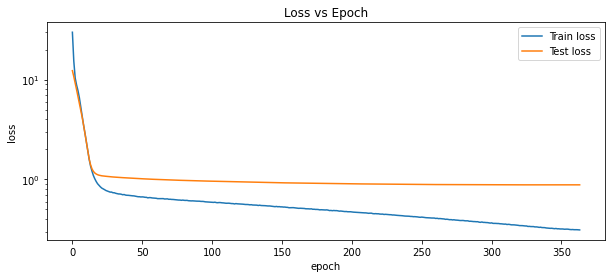

In [46]:
%%time

'''
Best Test RMSE=0.937, was obtained by config=5
Hyperparameters used: {'Iterations': 1000, 'Hid_dim_size': 250, 'Learning_Rate': 0.0005, 'Dropout': 0, 'Batch_size': 256
'''

def train_autorec_user_content(hidden_dims=[250],lr=0.0005,epochs=500,dropout=0,batch_size=256, \
                               content_gain = 100 , content_cols = 35 , \
                               verbose=False , activation=Sigmoid(),optimizer='adam',wd=2*1e-4):
    
    autorec_user_content_criterion  = autorec_mse_loss
    autorec_user_content_model      = AutoRec(input_dim = train_content_user.shape[1],hidden_dims = hidden_dims,dropout=dropout).to(device) 

    #init_param(autorec_user_content_model)  # for normal dist
    num_params = autorec_user_content_model.num_params()
    if verbose:          
        print(autorec_user_content_model,"\n")
        print('Model parameters:',num_params)      
    
    if optimizer=='adam':
        autorec_user_content_optim  = Adam(autorec_user_content_model.parameters(), lr=lr,weight_decay=wd) 
    else:
        print('SGD')
        autorec_user_content_optim  = SGD(autorec_user_content_model.parameters(), lr=lr,weight_decay=wd,momentum=0.9) 
    
    scheduler = lr_scheduler.ReduceLROnPlateau(autorec_user_content_optim, mode='min', 
                                             factor=0.7, patience=10,min_lr=0.0001, verbose=True)
  
    
    #create the data loader
    dl_train_users,_,dl_test_users,_ = create_autorec_dataloader_content(train_content_user, batch_size=batch_size)
  
    runner_autorec_user_content = Runner_AutoRec(autorec_user_content_model, train_content_user.values ,\
                                               test_content_user.values , device ,
                                                content_gain = content_gain , content_cols = content_cols)  
    
    train_loss,val_loss = runner_autorec_user_content.train_network(autorec_user_content_optim, \
                                                                    autorec_user_content_criterion ,
                                                                    dl_train_users ,dl_test_users, 
                                                                    num_epoch = epochs , early_stopping = 30, \
                                                                    verbose=verbose,scheduler=scheduler)
        
    return runner_autorec_user_content,train_loss,val_loss

def evaluate_autorec_user_content(runner_autorec_user_content,save_results , model_name = 'AutoRec_User_Content'):
  # Evaluation
    pred = runner_autorec_user_content.predict_all(train_content_user.values).detach().cpu().numpy()
    return model_eval (model_name , runner_autorec_user_content , test_content_user.values,pred,save_results)

runner_autorec_user_content,_,_ = train_autorec_user_content(verbose=True)

print(evaluate_autorec_user_content(runner_autorec_user_content,save_results=True))

runner_autorec_user_content.loss_graph()


In [47]:
final_results

,Method,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10,Time,Params
0,MF_NN,0.925,0.977,0.977,0.959,0.964,51.742356,52540
1,AutoRec_User,0.941,0.974,0.974,0.958,0.963,25.838136,338182
2,AutoRec_Item,0.894,0.967,0.967,0.967,0.971,6.616138,755743
3,AutoRec_User_Content,0.939,0.971,0.971,0.957,0.961,24.653378,860467


## Auto Rec Item Content ##

In [48]:
col_movies = ['movie id','Action','Adventure','Animation',
            'Childrens','Comedy','Crime','Documentary','Drama','Fantasy',\
             'Film_Noir','Horror','Musical',\
            'Mystery','Romance', 'Sci_Fi','Thriller','War','Western']

movies_profile_genere_basic_df = df_items[col_movies] \
                                .set_index('movie id')

movies_profile_genere_basic_df.sort_index(axis=0, inplace=True)

movies_profile_genere_basic_df.sort_index(axis=0, inplace=True)

movies_profile_df = movies_profile_genere_basic_df

df_zero           = movies_profile_df.T*0
test_content_item = pd.concat((test , df_zero))

In [49]:
train_content_item      = pd.concat((train , movies_profile_df.T))


AutoRec(
  (autorec_sequential): Sequential(
    (0): Linear(in_features=961, out_features=250, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=250, out_features=961, bias=True)
    (3): Identity()
  )
) 

Model parameters: 481711
Epoch 1,Train loss  : 19.355,Test loss    : 8.663
Epoch 51,Train loss  : 0.551,Test loss    : 0.852
Epoch 101,Train loss  : 0.460,Test loss    : 0.804
Epoch 151,Train loss  : 0.410,Test loss    : 0.789
Epoch 201,Train loss  : 0.394,Test loss    : 0.788
Early stoping after 216 epochs. Test loss did not imporve for more than 30 epcochs

Finished Training, Train loss=0.396, Test loss=0.788
('AutoRec_Item_Content', 0.887, 0.967, 0.967, 0.968, 0.971, 14.042579199999977, 481711)
Wall time: 14.7 s


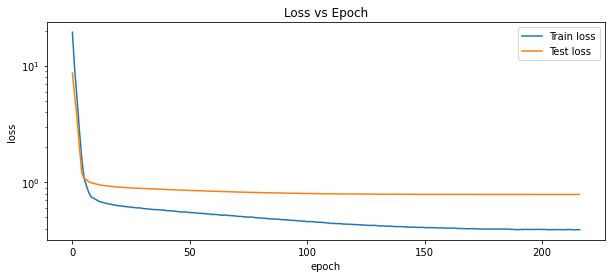

In [50]:
%%time

'''
Best Test RMSE=0.889, was obtained by config=2
Hyperparameters used: {'Iterations': 1000, 'Hid_dim_size': 250, 'Learning_Rate': 0.001, 'Dropout': 0, 'Batch_size': 256
'''

def train_autorec_item_content(hidden_dims=[250],lr=0.001,epochs=500,dropout=0,batch_size=256,verbose=False ,\
                               content_gain = 100 , content_cols = 18 , \
                              activation=Sigmoid(),optimizer='adam',wd=7*1e-4):

    autorec_item_content_criterion  = autorec_mse_loss
    autorec_item_content_model      = AutoRec(input_dim = train_content_item.shape[0],\
                                              hidden_dims = hidden_dims,dropout=dropout).to(device) 

    #init_param(autorec_item_content_model)  # for normal dist
    num_params = autorec_item_content_model.num_params()
    if verbose:
        print(autorec_item_content_model,"\n")
        print('Model parameters:',num_params)
    
    if optimizer=='adam':
        autorec_item_content_optim  = Adam(autorec_item_content_model.parameters(), lr=lr,weight_decay=wd) 
    else:
        print('SGD')
        autorec_item_content_optim  = SGD(autorec_item_content_model.parameters(), lr=lr,weight_decay=wd,momentum=0.9) 
    

    scheduler = lr_scheduler.ReduceLROnPlateau(autorec_item_content_optim, mode='min', 
                                             factor=0.8, patience=3, verbose=False)

    #create the data loader
    _,dl_train_items,_,dl_test_items = create_autorec_dataloader_content(train_content_item, batch_size=batch_size)
  
    runner_autorec_item_content = Runner_AutoRec(autorec_item_content_model, train_content_item.values.T ,\
                                               test_content_item.values.T , device ,\
                                                content_gain = content_gain , content_cols = content_cols)  
    
    train_loss,val_loss = runner_autorec_item_content.train_network(autorec_item_content_optim, autorec_item_content_criterion ,
                                                          dl_train_items ,dl_test_items, 
                                                          num_epoch = epochs , early_stopping = 30, \
                                                          verbose=verbose,scheduler=scheduler)
    
    return runner_autorec_item_content,train_loss,val_loss

def evaluate_autorec_item_content(runner_autorec_item_content,save_results,model_name = 'AutoRec_Item_Content'):
  # Evaluation
    pred = runner_autorec_item_content.predict_all(train_content_item.values.T).detach().cpu().numpy()
    return model_eval (model_name , runner_autorec_item_content , test_content_item.values.T,pred,save_results)

runner_autorec_item_content,_,_ = train_autorec_item_content(verbose=True)

print(evaluate_autorec_item_content(runner_autorec_item_content,save_results=True))

runner_autorec_item_content.loss_graph()

In [51]:
final_results

,Method,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10,Time,Params
0,MF_NN,0.925,0.977,0.977,0.959,0.964,51.742356,52540
1,AutoRec_User,0.941,0.974,0.974,0.958,0.963,25.838136,338182
2,AutoRec_Item,0.894,0.967,0.967,0.967,0.971,6.616138,755743
3,AutoRec_User_Content,0.939,0.971,0.971,0.957,0.961,24.653378,860467
4,AutoRec_Item_Content,0.887,0.967,0.967,0.968,0.971,14.042579,481711


## Auto Rec Item Content  Advance ##

In [52]:
class AutoRec_content2(nn.Module):
    def __init__(self, input_dim , main_dim , hidden_dims = [150], dropout = 0): # Must have at least 1 hidden layer
        super(AutoRec_content2 , self).__init__()

        hidden_dim    = hidden_dims[0]
        
        self.main_dim = main_dim
        side_dim      = input_dim - main_dim

        self.layer_main_1 = Linear(main_dim, hidden_dim)
        self.layer_side_1 = Linear(side_dim, hidden_dim , bias = False)
        
        self.sigmoid      = Sigmoid()    # Activation Layer   
        
        self.layer_main_2 = Linear(hidden_dim, input_dim)
        self.layer_side_2 = Linear(side_dim, input_dim, bias = False)
        
    def forward(self, vect):
        
        main_vect = vect[: , 0:self.main_dim]
        side_vect = vect[:, self.main_dim::]
        
        x1  = self.layer_main_1(main_vect)
        y1  = self.layer_side_1(side_vect)
        z1  = x1+y1   
        z11 = self.sigmoid(z1)
        
        x2 = self.layer_main_2(z11)
        y2 = self.layer_side_2(side_vect)
        z2 = x2+y2
                
        autorec_result = z2 #squeeze()     

        return autorec_result
    
    def num_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [53]:
train_content_item2 = pd.concat((train , movies_profile_df.T))

AutoRec_content2(
  (layer_main_1): Linear(in_features=943, out_features=100, bias=True)
  (layer_side_1): Linear(in_features=18, out_features=100, bias=False)
  (sigmoid): Sigmoid()
  (layer_main_2): Linear(in_features=100, out_features=961, bias=True)
  (layer_side_2): Linear(in_features=18, out_features=961, bias=False)
) 

Model parameters: 210559
Epoch 1,Train loss  : 8.185,Test loss    : 3.517
Epoch 51,Train loss  : 0.511,Test loss    : 0.803
Early stoping after 82 epochs. Test loss did not imporve for more than 30 epcochs

Finished Training, Train loss=0.500, Test loss=0.801
('AutoRec_Item_Advance', 0.895, 0.963, 0.963, 0.967, 0.971, 11.412946800000043, 210559)
Wall time: 12 s


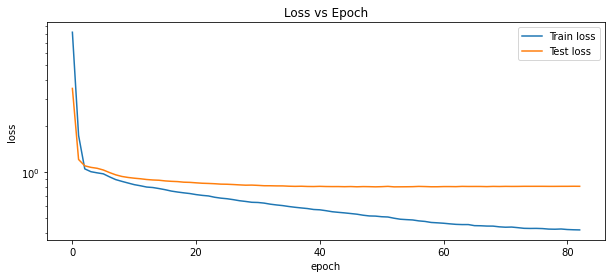

In [54]:
%%time

'''
Best Test RMSE=0.927, was obtained by config=0
Hyperparameters used: {'Iterations': 1000, 'Hid_dim_size': 100, 'Learning_Rate': 0.001, 'Dropout': 0, 'Batch_size': 64
'''

def train_autorec_item_content2(hidden_dims=[100],lr=0.001,epochs=500,dropout=0,batch_size=64,verbose=False ,\
                               activation=Sigmoid(),optimizer='adam',wd=5*1e-4):
    
    autorec_item_content2_criterion  = autorec_mse_loss
    autorec_item_content2_model      = AutoRec_content2(input_dim = train_content_item2.shape[0],main_dim = train.shape[0], \
                                                       hidden_dims = hidden_dims,dropout=dropout).to(device) 

    #init_param(autorec_item_content2_model)  # for normal dist
    num_params = autorec_item_content2_model.num_params()
    if verbose:
        print(autorec_item_content2_model,"\n")
        print('Model parameters:',num_params)

    if optimizer=='adam':
        autorec_item_content2_optim  = Adam(autorec_item_content2_model.parameters(), lr=lr,weight_decay=wd) 
    else:
        print('SGD')
        autorec_item_content2_optim  = SGD(autorec_item_content2_model.parameters(), lr=lr,weight_decay=wd,momentum=0.9) 
  
    scheduler = lr_scheduler.ReduceLROnPlateau(autorec_item_content2_optim, mode='min', 
                                             factor=0.8, patience=3, verbose=False)

    #create the data loader
    _,dl_train_items,_,dl_test_items = create_autorec_dataloader_content(train_content_item2, batch_size=batch_size)
  
    runner_autorec_item_content2 = Runner_AutoRec(autorec_item_content2_model, train_content_item2.values.T ,\
                                               test_content_item.values.T , device)  
    
    train_loss,val_loss = runner_autorec_item_content2.train_network(autorec_item_content2_optim, \
                                                                     autorec_item_content2_criterion ,
                                                                      dl_train_items ,dl_test_items, 
                                                                      num_epoch = epochs , early_stopping = 30,\
                                                                    verbose=verbose , \
                                                                    scheduler=scheduler)
    
    return runner_autorec_item_content2,train_loss,val_loss

def evaluate_autorec_item_content2(runner_autorec_item_content2,save_results, model_name = 'AutoRec_Item_Advance'):
  # Evaluation
    pred = runner_autorec_item_content2.predict_all(train_content_item2.values.T).detach().cpu().numpy()
    return model_eval (model_name , runner_autorec_item_content2 , test_content_item.values.T,pred,save_results)


runner_autorec_item_content2,_,_ = train_autorec_item_content2(verbose=True)

print(evaluate_autorec_item_content2(runner_autorec_item_content2,save_results=True))

runner_autorec_item_content2.loss_graph()

In [55]:
final_results

,Method,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10,Time,Params
0,MF_NN,0.925,0.977,0.977,0.959,0.964,51.742356,52540
1,AutoRec_User,0.941,0.974,0.974,0.958,0.963,25.838136,338182
2,AutoRec_Item,0.894,0.967,0.967,0.967,0.971,6.616138,755743
3,AutoRec_User_Content,0.939,0.971,0.971,0.957,0.961,24.653378,860467
4,AutoRec_Item_Content,0.887,0.967,0.967,0.968,0.971,14.042579,481711
5,AutoRec_Item_Advance,0.895,0.963,0.963,0.967,0.971,11.412947,210559


**Various latent space sizes for the AutoRec Content based models**

In [56]:
models['AutoRec_User_content'] = {'model_train_func':'train_autorec_user_content','model_eval_func':'evaluate_autorec_user_content'}
models['AutoRec_Item_content'] = {'model_train_func':'train_autorec_item_content','model_eval_func':'evaluate_autorec_item_content'}
models['AutoRec_Item_content2'] = {'model_train_func':'train_autorec_item_content2','model_eval_func':'evaluate_autorec_item_content2'}


latent dim = 30
AutoRec_User_content RMSE: 1.007
AutoRec_Item_content RMSE: 0.925

latent dim = 50
AutoRec_User_content RMSE: 0.978
AutoRec_Item_content RMSE: 0.902

latent dim = 100
AutoRec_User_content RMSE: 0.944
Early stoping after 337 epochs. Test loss did not imporve for more than 30 epcochs
AutoRec_Item_content RMSE: 0.891

latent dim = 150
Epoch   484: reducing learning rate of group 0 to 3.5000e-04.
Epoch   495: reducing learning rate of group 0 to 2.4500e-04.
AutoRec_User_content RMSE: 0.939
Early stoping after 254 epochs. Test loss did not imporve for more than 30 epcochs
AutoRec_Item_content RMSE: 0.888

latent dim = 200
Epoch   397: reducing learning rate of group 0 to 3.5000e-04.
Epoch   408: reducing learning rate of group 0 to 2.4500e-04.
Early stoping after 415 epochs. Test loss did not imporve for more than 30 epcochs
AutoRec_User_content RMSE: 0.938
Early stoping after 258 epochs. Test loss did not imporve for more than 30 epcochs
AutoRec_Item_content RMSE: 0.886

l

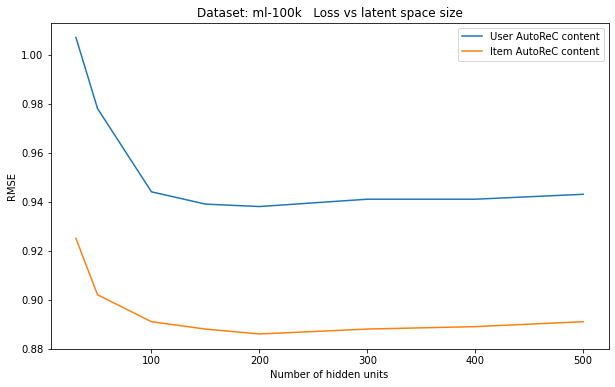

In [57]:
def plot_rmse_vs_latent_dim_content():
    latent_dim = [30, 50 ,100 , 150 , 200 , 300 ,  400, 500]

    AutoRec_User_content_list  = []
    AutoRec_Item_content_list  = [] 
    AutoRec_Item_content2_list = [] 
    
    for dim_size  in latent_dim:
        print ("\nlatent dim = {}".format(dim_size))
        for model_name in ["AutoRec_User_content" , "AutoRec_Item_content"]:
            trn_f = globals()[models[model_name]['model_train_func']]
            model_runner,train_loss,test_loss = trn_f(hidden_dims=[dim_size],verbose=False)
            evl_f = globals()[models[model_name]['model_eval_func']]
            name , rmse_eval, mrr10 , mrr5 , ndcg10, ndcg5 , time,_ = evl_f(model_runner,save_results=False)
            locals()[model_name+"_list"].append(rmse_eval)
        
            print ("{} RMSE: {}".format(model_name,rmse_eval))
   
   
    fig, ax = plt.subplots(1, 1,figsize=(10, 6))

    ax.set_title('Dataset: {}   Loss vs latent space size'.format(dataset_name))
    ax.set_xlabel('Number of hidden units')
    ax.set_ylabel('RMSE')
    ax.plot(latent_dim, AutoRec_User_content_list,   label   = "User AutoReC content")
    ax.plot(latent_dim , AutoRec_Item_content_list,  label   = "Item AutoReC content")
    ax.legend()
    

plot_rmse_vs_latent_dim_content()

**Various content gain  for the content based models**


 AutoRec_User_content  Content gain = 1
Epoch   307: reducing learning rate of group 0 to 3.5000e-04.
Epoch   318: reducing learning rate of group 0 to 2.4500e-04.
Early stoping after 325 epochs. Test loss did not imporve for more than 30 epcochs
AutoRec_User_content RMSE: 0.939

 AutoRec_Item_content  Content gain = 1
Early stoping after 122 epochs. Test loss did not imporve for more than 30 epcochs
AutoRec_Item_content RMSE: 0.89

 AutoRec_User_content  Content gain = 5
Epoch   294: reducing learning rate of group 0 to 3.5000e-04.
Epoch   317: reducing learning rate of group 0 to 2.4500e-04.
Epoch   328: reducing learning rate of group 0 to 1.7150e-04.
Early stoping after 335 epochs. Test loss did not imporve for more than 30 epcochs
AutoRec_User_content RMSE: 0.941

 AutoRec_Item_content  Content gain = 5
Early stoping after 123 epochs. Test loss did not imporve for more than 30 epcochs
AutoRec_Item_content RMSE: 0.889

 AutoRec_User_content  Content gain = 10
Epoch   271: reducing

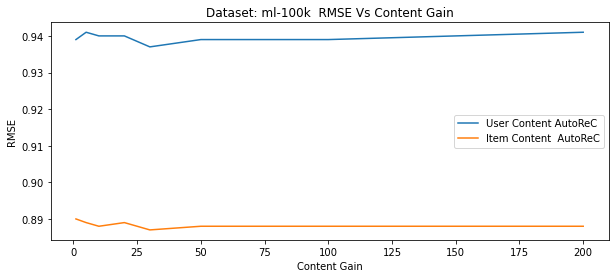

In [59]:
content_gain_list = [1,  5 , 10 , 20,30,50,100,200]

AutoRec_User_content_list = []
AutoRec_Item_content_list = [] 

for content_gain  in content_gain_list:
    for model_name in ["AutoRec_User_content" ,"AutoRec_Item_content"]:
        #train_content_item , test_content_item = globals()[models_content[model_name]['set_gain_func']](content_gain)
        trn_f = globals()[models[model_name]['model_train_func']]
        print ("\n {}  Content gain = {}".format(model_name,content_gain))
        model_runner,train_loss,test_loss = trn_f(content_gain = content_gain , verbose=False)
        evl_f = globals()[models[model_name]['model_eval_func']]
        name , rmse_eval, mrr10 , mrr5 , ndcg10, ndcg5 , time,_ = evl_f(model_runner,save_results=False)
        globals()[model_name+"_list"].append(rmse_eval)
        
        print ("{} RMSE: {}".format(model_name,rmse_eval))
      
fig, ax = plt.subplots(1, 1,figsize=(10, 4))
ax.set_title('Dataset: {}  RMSE Vs Content Gain'.format(dataset_name))
ax.set_xlabel('Content Gain')
ax.set_ylabel('RMSE')
ax.plot(content_gain_list, AutoRec_User_content_list, label = "User Content AutoReC")
ax.plot(content_gain_list , AutoRec_Item_content_list, label = "Item Content  AutoReC")
ax.legend()

## Cold Start

**Item**

In [60]:
# Save for later testing 
test_old = test.copy()
cold_start_results = pd.DataFrame(columns=['Method','RMSE','MRR_5','MRR_10','NDCG_5','NDCG_10','Time','Params'])

In [61]:
# Single rating per item in the test data set
test         = test_old * 0  
for col in test_old.columns:
    nonzero_vect = np.where(test_old[col] >0)
    if (nonzero_vect[0].size>0):
        sel          = np.random.randint(low = 0, high=nonzero_vect[0].size, size=1, dtype=int)
        user_sel     = nonzero_vect[0][sel] + 1  # +1 as first index is 1
        test.loc[user_sel , col]  = test_old.loc[user_sel , col]

In [62]:
# AutoReC Item
runner_autorec_item,_,_ = train_autorec_item(verbose=True)

name , rmse, mrr10 , mrr5 , ndcg10, ndcg5 , time , params = evaluate_autorec_item(runner_autorec_item,save_results = False)
cold_start_results.loc[len(cold_start_results)] = name , rmse, mrr10 , mrr5 , ndcg10, ndcg5 , time , params


# AutoRec Item Content
df_zero           = movies_profile_df.T*0
test_content_item = pd.concat((test , df_zero))

runner_autorec_item_content,_,_ = train_autorec_item_content(verbose=True)

name , rmse, mrr10 , mrr5 , ndcg10, ndcg5 , time , params = \
    evaluate_autorec_item_content(runner_autorec_item_content,save_results = False)

cold_start_results.loc[len(cold_start_results)] = name , rmse, mrr10 , mrr5 , ndcg10, ndcg5 , time , params


# AutoRec Item Content advance
runner_autorec_item_content2,_,_ = train_autorec_item_content2(verbose=True)

name , rmse, mrr10 , mrr5 , ndcg10, ndcg5 , time , params = \
    evaluate_autorec_item_content2(runner_autorec_item_content2,save_results = False)

cold_start_results.loc[len(cold_start_results)] = name , rmse, mrr10 , mrr5 , ndcg10, ndcg5 , time , params


AutoRec(
  (autorec_sequential): Sequential(
    (0): Linear(in_features=943, out_features=400, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=400, out_features=943, bias=True)
    (3): Identity()
  )
) 

Model parameters: 755743
Epoch 1,Train loss  : 11.743,Test loss    : 5.167
Epoch 51,Train loss  : 0.720,Test loss    : 0.899
Epoch 101,Train loss  : 0.542,Test loss    : 0.870
Epoch 151,Train loss  : 0.471,Test loss    : 0.869
Early stoping after 158 epochs. Test loss did not imporve for more than 30 epcochs

Finished Training, Train loss=0.491, Test loss=0.868
AutoRec(
  (autorec_sequential): Sequential(
    (0): Linear(in_features=961, out_features=250, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=250, out_features=961, bias=True)
    (3): Identity()
  )
) 

Model parameters: 481711
Epoch 1,Train loss  : 20.643,Test loss    : 6.967
Epoch 51,Train loss  : 0.562,Test loss    : 0.917
Epoch 101,Train loss  : 0.484,Test loss    : 0.886
Epoch 151,Train loss  : 0.43

**Result Summary Item Cold Start**

In [63]:
cold_start_results

,Method,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10,Time,Params
0,AutoRec_Item,0.931,1.0,1.0,1.0,1.0,8.678812,755743
1,AutoRec_Item_Content,0.930,1.0,1.0,1.0,1.0,16.324136,481711
2,AutoRec_Item_Advance,0.951,1.0,1.0,1.0,1.0,11.415441,210559


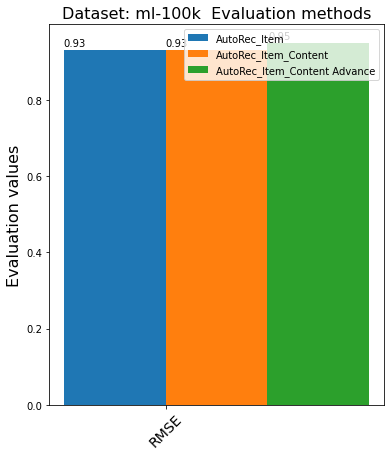

In [64]:
labels = ["RMSE"]
x = np.arange(len(labels))

AutoRec_Item = [cold_start_results.loc[0,'RMSE']]
                
AutoRec_Item_Content = [cold_start_results.loc[1,'RMSE']]
                       
AutoRec_Item_Content2 = [cold_start_results.loc[2,'RMSE']]
                         
        

AutoRec_Item           = [ int(i*100)/100  for i in AutoRec_Item]
AutoRec_Item_Content    = [ int(i*100)/100  for i in AutoRec_Item_Content]
AutoRec_Item_Content2    = [ int(i*100)/100  for i in AutoRec_Item_Content2]


fig, ax = plt.subplots(1, 1, figsize=(6, 7))
width = 0.3
ax.bar(x - width/2, AutoRec_Item , width, label='AutoRec_Item')
ax.bar(x + width/2, AutoRec_Item_Content , width, label='AutoRec_Item_Content')
ax.bar(x + (3/2)*width, AutoRec_Item_Content2, width, label='AutoRec_Item_Content Advance')
ax.set_title("Dataset: {}  Evaluation methods".format(dataset_name), fontsize=16)
ax.set_ylabel("Evaluation values", fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels ,fontsize=14,rotation=45)
ax.legend()

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.010, p.get_height() * 1.010))

**User**

In [65]:
# Single rating per item in the test data set
test         = test_old * 0  
for row in test_old.index:
    nonzero_vect = np.where(test_old.loc[row] >0)
    if (nonzero_vect[0].size>0):
        sel          = np.random.randint(low = 0, high=nonzero_vect[0].size, size=1, dtype=int)
        item_sel     = nonzero_vect[0][sel] + 1  # +1 as first col is 1
        test.loc[row , item_sel]  = test_old.loc[row , item_sel]

In [66]:
# AutoReC User
runner_autorec_user,_,_ = train_autorec_user(verbose=True)

name , rmse, mrr10 , mrr5 , ndcg10, ndcg5 , time , params = evaluate_autorec_user(runner_autorec_user,save_results = False)
cold_start_results.loc[len(cold_start_results)] = name , rmse, mrr10 , mrr5 , ndcg10, ndcg5 , time , params


# AutoReC User Content
df_zero            = users_profile_df*0
test_content_user  = pd.concat((test , df_zero) ,axis = 1)

runner_autorec_user_content,_,_ = train_autorec_user_content(verbose=True)

name , rmse, mrr10 , mrr5 , ndcg10, ndcg5 , time , params = evaluate_autorec_user_content(runner_autorec_user_content,save_results = False)
cold_start_results.loc[len(cold_start_results)] = name , rmse, mrr10 , mrr5 , ndcg10, ndcg5 , time , params

AutoRec(
  (autorec_sequential): Sequential(
    (0): Linear(in_features=1682, out_features=100, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=100, out_features=1682, bias=True)
    (3): Identity()
  )
) 

Model parameters: 338182
Epoch 1,Train loss  : 13.752,Test loss    : 13.130
Epoch 51,Train loss  : 1.014,Test loss    : 1.077
Early stoping after 96 epochs. Test loss did not imporve for more than 30 epcochs

Finished Training, Train loss=0.988, Test loss=1.014
AutoRec(
  (autorec_sequential): Sequential(
    (0): Linear(in_features=1717, out_features=250, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=250, out_features=1717, bias=True)
    (3): Identity()
  )
) 

Model parameters: 860467
Epoch 1,Train loss  : 33.318,Test loss    : 12.666
Epoch 51,Train loss  : 0.671,Test loss    : 1.030
Epoch 101,Train loss  : 0.598,Test loss    : 0.990
Epoch 151,Train loss  : 0.539,Test loss    : 0.970
Epoch 201,Train loss  : 0.482,Test loss    : 0.957
Epoch 251,Train loss  :

In [67]:
cold_start_results

,Method,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10,Time,Params
0,AutoRec_Item,0.931,1.0,1.0,1.0,1.0,8.678812,755743
1,AutoRec_Item_Content,0.930,1.0,1.0,1.0,1.0,16.324136,481711
2,AutoRec_Item_Advance,0.951,1.0,1.0,1.0,1.0,11.415441,210559
3,AutoRec_User,1.007,1.0,1.0,1.0,1.0,4.706039,338182
4,AutoRec_User_Content,0.964,1.0,1.0,1.0,1.0,32.718133,860467


In [68]:
test = test_old.copy()

## <br>

## 2. Deep Autoencoder Recommendation

Creating a deeper network while keeping the same number of parameters
<br>

## Deep AutoRec User

AutoRec(
  (autorec_sequential): Sequential(
    (0): Linear(in_features=1682, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ELU(alpha=1.0)
    (4): Dropout(p=0.8, inplace=False)
    (5): Linear(in_features=512, out_features=256, bias=True)
    (6): ELU(alpha=1.0)
    (7): Linear(in_features=256, out_features=1682, bias=True)
    (8): Identity()
  )
) 

Model parameters: 1126034
SGD
Epoch 1,Train loss  : 13.543,Test loss    : 13.249
Epoch 86,Train loss  : 0.890,Test loss    : 0.995
Epoch 171,Train loss  : 0.837,Test loss    : 0.950
Early stoping after 196 epochs. Test loss did not imporve for more than 30 epcochs

Finished Training, Train loss=0.844, Test loss=0.946
('DeepAutoRec_User', 0.978, 0.978, 0.978, 0.956, 0.961, 19.70408629999997, 1126034)
Wall time: 20.4 s


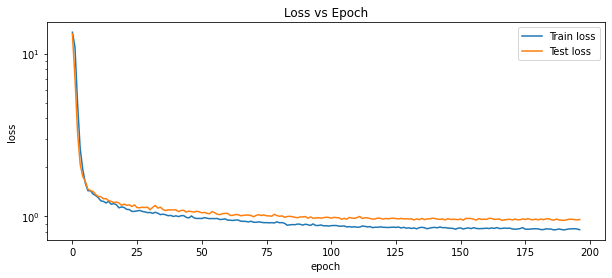

In [69]:
%%time

#Best single - RMSE: 0.873
#hidden_dims=[100],lr=0.003,epochs=500,dropout=0,batch_size=1024,activation=Sigmoid()
#dest deep
#4M params , 0.879 runner_autorec_user,_,_ = train_autorec_user(epochs=2000,activation=ReLU(),hidden_dims=[100,64,100],lr=0.0001,batch_size=256,dropout=0.3,verbose=True)
'''
# 0.873 runner_autorec_user,_,_ = train_autorec_user(epochs=1500,activation=ELU(),hidden_dims=[512, 256, 512],
                                            #  lr=0.01,batch_size=128,dropout=0.7,verbose=True,optimizer='sgd')
Same as "diamond" arch:
runner_autorec_user,_,_ = train_autorec_user(epochs=850,activation=ELU(),hidden_dims=[256,512,256],
                                             lr=0.01,batch_size=100,dropout=0.8,verbose=True,optimizer='sgd')           
'''
runner_autorec_user,_,_ = train_autorec_user(epochs=850,activation=ELU(),hidden_dims=[256,512,256],
                                             lr=0.01,batch_size=100,dropout=0.8,verbose=True,optimizer='sgd')
print(evaluate_autorec_user(runner_autorec_user,model_name='DeepAutoRec_User',save_results=True))

runner_autorec_user.loss_graph()

In [70]:
final_results.groupby('Method').min('RMSE')

,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10,Time
Method,,,,,,
AutoRec_Item,0.894,0.967,0.967,0.967,0.971,6.616138
AutoRec_Item_Advance,0.895,0.963,0.963,0.967,0.971,11.412947
AutoRec_Item_Content,0.887,0.967,0.967,0.968,0.971,14.042579
AutoRec_User,0.941,0.974,0.974,0.958,0.963,25.838136
AutoRec_User_Content,0.939,0.971,0.971,0.957,0.961,24.653378
DeepAutoRec_User,0.978,0.978,0.978,0.956,0.961,19.704086
MF_NN,0.925,0.977,0.977,0.959,0.964,51.742356


## Deep AutoRec Item

AutoRec(
  (autorec_sequential): Sequential(
    (0): Linear(in_features=943, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=400, bias=True)
    (5): ReLU()
    (6): Linear(in_features=400, out_features=943, bias=True)
    (7): Identity()
  )
) 

Model parameters: 916343
SGD
Epoch 1,Train loss  : 13.738,Test loss    : 13.850
Epoch 151,Train loss  : 0.841,Test loss    : 0.904
Epoch 301,Train loss  : 0.780,Test loss    : 0.865
Epoch 451,Train loss  : 0.719,Test loss    : 0.832
Epoch 601,Train loss  : 0.679,Test loss    : 0.818
Early stoping after 707 epochs. Test loss did not imporve for more than 30 epcochs

Finished Training, Train loss=0.678, Test loss=0.817
('DeepAutoRec_Item', 0.904, 0.958, 0.958, 0.965, 0.969, 41.858350900000005, 916343)
Wall time: 42.5 s


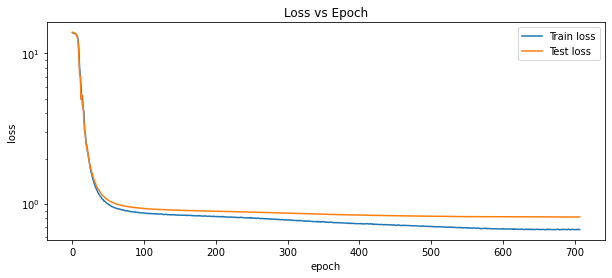

In [71]:
%%time

#BEST single: 0.838.... 
#hidden_dims=[400],lr=0.003,epochs=500,dropout=0,batch_size=1024,activation=Sigmoid())
#dest deep
#0.888 same params: runner_autorec_item,_,_ = train_autorec_item(activation=ReLU(),hidden_dims=[400,100,400],lr=0.005,batch_size=512,dropout=0.5,verbose=True)
#0.859
# runner_autorec_item,_,_ = train_autorec_item(hidden_dims=[400,200,400],
                                            #  epochs=1500,lr=0.01,
                                            #  activation=ReLU(),
                                            #  verbose=True,optimizer='sgd',wd=0.001)

runner_autorec_item,_,_ = train_autorec_item(hidden_dims=[400,200,400],
                                             epochs=1500,lr=0.01,
                                             activation=ReLU(),
                                             verbose=True,optimizer='sgd',wd=0.001)

print(evaluate_autorec_item(runner_autorec_item,model_name='DeepAutoRec_Item',save_results=True))

runner_autorec_item.loss_graph()

In [72]:
final_results

,Method,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10,Time,Params
0,MF_NN,0.925,0.977,0.977,0.959,0.964,51.742356,52540
1,AutoRec_User,0.941,0.974,0.974,0.958,0.963,25.838136,338182
2,AutoRec_Item,0.894,0.967,0.967,0.967,0.971,6.616138,755743
3,AutoRec_User_Content,0.939,0.971,0.971,0.957,0.961,24.653378,860467
4,AutoRec_Item_Content,0.887,0.967,0.967,0.968,0.971,14.042579,481711
5,AutoRec_Item_Advance,0.895,0.963,0.963,0.967,0.971,11.412947,210559
6,DeepAutoRec_User,0.978,0.978,0.978,0.956,0.961,19.704086,1126034
7,DeepAutoRec_Item,0.904,0.958,0.958,0.965,0.969,41.858351,916343


In [73]:
#final_results.groupby('Method').min('RMSE')

## Improvements   Results Summary

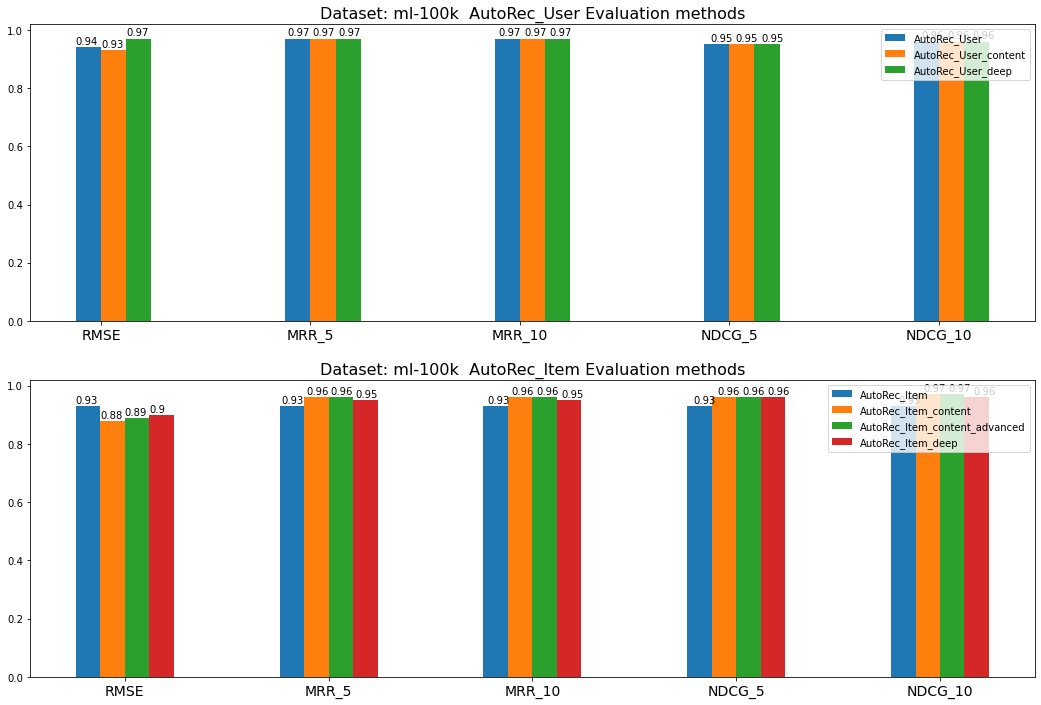

In [74]:
labels = ["RMSE" , "MRR_5" , "MRR_10", "NDCG_5" ,"NDCG_10" ]
x = np.arange(len(labels))

AutoRec_User_content = [final_results.loc[3,'RMSE'] , \
                       final_results.loc[3,'MRR_5'] , \
                       final_results.loc[3,'MRR_10'] , \
                       final_results.loc[3,'NDCG_5'] , \
                       final_results.loc[3,'NDCG_10']]

AutoRec_User_deep = [final_results.loc[6,'RMSE'] , \
                    final_results.loc[6,'MRR_5'] , \
                    final_results.loc[6,'MRR_10'] , \
                    final_results.loc[6,'NDCG_5'] , \
                    final_results.loc[6,'NDCG_10']]

AutoRec_Item_content = [final_results.loc[4,'RMSE'] , \
                       final_results.loc[4,'MRR_5'] , \
                       final_results.loc[4,'MRR_10'] , \
                       final_results.loc[4,'NDCG_5'] , \
                       final_results.loc[4,'NDCG_10']]

AutoRec_Item_content_advanced = [final_results.loc[5,'RMSE'] , \
                                 final_results.loc[5,'MRR_5'] , \
                                 final_results.loc[5,'MRR_10'] , \
                                 final_results.loc[5,'NDCG_5'] , \
                                 final_results.loc[5,'NDCG_10']]


AutoRec_Item_deep = [final_results.loc[7,'RMSE'] , \
                    final_results.loc[7,'MRR_5'] , \
                    final_results.loc[7,'MRR_10'] , \
                    final_results.loc[7,'NDCG_5'] , \
                    final_results.loc[7,'NDCG_10']] 
        

AutoRec_User_content          = [ int(i*100)/100  for i in AutoRec_User_content]
AutoRec_User_deep             = [ int(i*100)/100  for i in AutoRec_User_deep]
AutoRec_Item_content          = [ int(i*100)/100  for i in AutoRec_Item_content]
AutoRec_Item_content_advanced = [ int(i*100)/100  for i in AutoRec_Item_content_advanced]
AutoRec_Item_deep             = [ int(i*100)/100  for i in AutoRec_Item_deep]

fig, ax = plt.subplots(2, 1, figsize=(18, 12))
width = 0.12
ax[0].set_title("Dataset: {}  AutoRec_User Evaluation methods".format(dataset_name), fontsize=16)

ax[0].bar(x - width/2, AutoRec_User , width, label='AutoRec_User')
ax[0].bar(x + width/2, AutoRec_User_content , width, label='AutoRec_User_content')
ax[0].bar(x + (3/2)*width, AutoRec_User_deep, width, label='AutoRec_User_deep')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels ,fontsize=14,rotation=0)
ax[0].legend()

for p in ax[0].patches:
    ax[0].annotate(str(p.get_height()), (p.get_x() * 1.010, p.get_height() * 1.010))

ax[1].set_title("Dataset: {}  AutoRec_Item Evaluation methods".format(dataset_name), fontsize=16)
ax[1].bar(x - (3/2)*width, AutoRec_Item , width, label='AutoRec_Item')
ax[1].bar(x - width/2, AutoRec_Item_content , width, label='AutoRec_Item_content')
ax[1].bar(x + (1/2)*width, AutoRec_Item_content_advanced, width, label='AutoRec_Item_content_advanced')
ax[1].bar(x + (3/2)*width, AutoRec_Item_deep, width, label='AutoRec_Item_deep')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels ,fontsize=14,rotation=0)
ax[1].legend()

for p in ax[1].patches:
    ax[1].annotate(str(p.get_height()), (p.get_x() * 1.010, p.get_height() * 1.010))

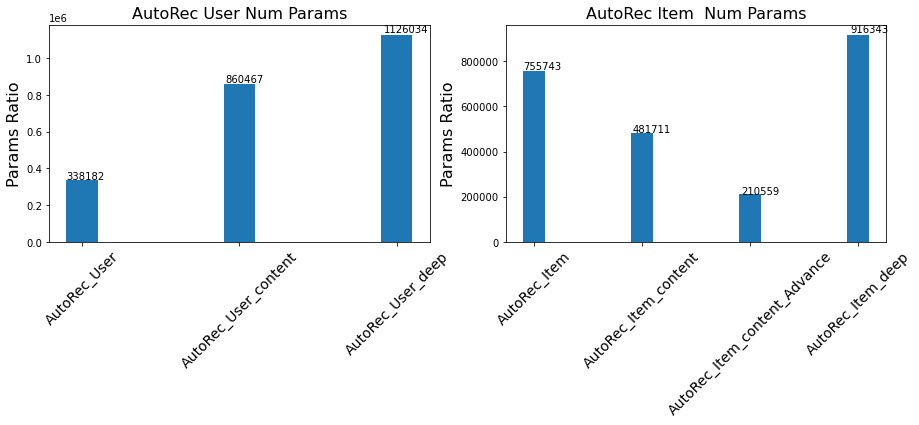

In [75]:
labels_user = ["AutoRec_User" , "AutoRec_User_content" , "AutoRec_User_deep" ]
x_user = np.arange(len(labels_user))

time_user = []
time_user.append(final_results.loc[1,'Params'])
time_user.append(final_results.loc[3,'Params'])
time_user.append(final_results.loc[6,'Params'])
time_max_user   =  max(time_user)
time_max_user   = [ round(i/time_max_user,2)  for i in time_user]


labels_item = ["AutoRec_Item" , "AutoRec_Item_content", "AutoRec_Item_content_Advance" , "AutoRec_Item_deep" ]
x_item = np.arange(len(labels_item))

time_item = []
time_item.append(final_results.loc[2,'Params'])
time_item.append(final_results.loc[4,'Params'])
time_item.append(final_results.loc[5,'Params'])
time_item.append(final_results.loc[7,'Params'])

time_max_item   =  max(time_item)
time_max_item   = [ round(i/time_max_item,2)  for i in time_item]


fig, ax = plt.subplots(1, 2, figsize=(15, 4))

width = 0.2
ax[0].bar(x_user ,time_user   , width)
ax[0].set_title("AutoRec User Num Params", fontsize=16)
ax[0].set_ylabel("Params Ratio", fontsize=16)
ax[0].set_xticks(x_user)
ax[0].set_xticklabels(labels_user ,fontsize=14,rotation=45)

for p in ax[0].patches:
    ax[0].annotate(str(p.get_height()), (p.get_x() * 1.010, p.get_height() * 1.010))


width = 0.2
ax[1].bar(x_item ,time_item   , width)    
ax[1].set_title("AutoRec Item  Num Params", fontsize=16)
ax[1].set_ylabel("Params Ratio", fontsize=16)
ax[1].set_xticks(x_item)
ax[1].set_xticklabels(labels_item ,fontsize=14,rotation=45)

for p in ax[1].patches:
    ax[1].annotate(str(p.get_height()), (p.get_x() * 1.010, p.get_height() * 1.010))

<br>

# HyperParams Search using KFold CV 

<br>

In [76]:
#Reset the results df
final_results_df = pd.DataFrame(columns=['Model_name','Hid_dim_size','Iterations','Learning_Rate','Dropout','Batch_size','RMSE','MRR_5','MRR_10','NDCG_5','NDCG_10','Time'])
all_results = pd.DataFrame(columns=final_results_df.columns)

In [77]:
def train_cv(model_name,n_iterations , hidden_dims , batch_size,
             dropout , learning_rate ,activation, number_of_folds ,final_results,verbose=True):

    if verbose:
      verbose_formatting = "{:10}\t{:10}\t{:10}\t{:10}\t{:10}\t{:10}\t{:10}\t{:4}\t{:4}\t{:4}"
      print (verbose_formatting.format("Model_name","Iter","Hid_dim_size","LR","Dropout","Batch_size","Fold", "Train Loss" , "Test Loss","RMSE"))
    
    config_num = 0
    best_tst_config_rmse, best_trn_config_loss, best_config_num = 10000,10000,config_num
    for n_iter in n_iterations:
        for hd in hidden_dims:
            for lr in learning_rate:
                for reg in dropout:
                  for act in activation:
                      for bs in batch_size:
                          dic = {'Iterations':n_iter,'Hid_dim_size':hd,
                                'Learning_Rate':lr,'Dropout':reg,
                                'Batch_size':bs,'Activation':act}
                          rmse, mrr_5,mrr_10,ndcg_5,ndcd_10,train_loss_sum,time_sum = 0,0,0,0,0,0,0
                          
                          for kfold in range(number_of_folds):                
                              train,test = getfulldf(*fold2df(kfold+1))
                              # train     = train_list[kfold]
                              # test      = test_list[kfold]
                          
                              # train model on Fold (calling the relevant model function dynamically)
                              trn_f = globals()[models[model_name]['model_train_func']]
                              model_runner,train_loss,test_loss = trn_f(hidden_dims=[hd],lr=lr,epochs=n_iter,dropout=reg,batch_size=bs,verbose=False,activation=act)

                              #evaluate model on Fold
                              evl_f = globals()[models[model_name]['model_eval_func']]
                              name , rmse_eval, mrr10 , mrr5 , ndcg10, ndcg5 , time, _ = evl_f(model_runner,save_results = True)
                              
                              train_loss_sum += train_loss
                              if verbose:
                                verbose_formatting2 = "{:10}\t{:10}\t{:10}\t{:10}\t{:10}\t{:10}\t{:10}\t{:4f}\t{:4f}\t{:4f}"
                                print (verbose_formatting2.format(model_name,str(n_iter),str(hd),str(lr),str(reg),str(bs),
                                                                  str(kfold) ,train_loss , test_loss,rmse_eval))        
                              
                              #summarize fold results
                              rmse     +=  rmse_eval
                              mrr_5    +=  mrr5
                              mrr_10   +=  mrr10
                              ndcg_5   +=  ndcg5
                              ndcd_10  +=  ndcg10
                              time_sum +=  time
                                                                
                          #average
                          dic['Config_num'] = config_num
                          dic['Model_name'] = model_name
                          dic['RMSE']     =  rmse/number_of_folds
                          dic['MRR_5']    =  mrr_5/number_of_folds
                          dic['MRR_10']   =  mrr_10/number_of_folds
                          dic['NDCG_5']   =  ndcg_5/number_of_folds
                          dic['NDCG_10']  =  ndcd_10/number_of_folds
                          dic['Time']     =  time_sum/number_of_folds
                          # dic['Params']   =  model_runner.model.num_params()
                  
                          avg_train_loss = train_loss_sum/number_of_folds
                          avg_test_rmse = dic['RMSE']
                          print ("\033[1mConfig Num {} Summary:  Average Test RMSE: {:.5f})\033[0m\n". \
                                  format(config_num , avg_test_rmse ))
                          #save best Config for model
                          if avg_test_rmse < best_tst_config_rmse:
                            best_tst_config_rmse = avg_test_rmse
                            best_trn_config_loss = avg_train_loss
                            best_hp = dic.copy()
                            best_config_num = config_num

                          # add experiment
                          final_results = final_results.append(dic,ignore_index=True)
                          config_num += 1
    print ("-----------------------------------{}--------------------------------------------------".format(model_name))
    print('Best Test RMSE={:.3f}, was obtained by config={}'.format(best_tst_config_rmse,best_config_num))
    print('Hyperparameters used:',best_hp)
    print ("=========================================================================================================\n")
    return final_results

## KFold CV for AutoRec User

In [78]:
%%time

'''
Best Test RMSE=0.878, was obtained by config=1
Hyperparameters used: {'Iterations': 500, 'Hid_dim_size': 200, 'Learning_Rate': 0.0002, 'Dropout': 0, 'Batch_size': 100
'''

number_of_folds = 5 #MAX_FOLD # 5       
#Iterations used for epochs
n_iterations   = [1000] #just one value due to computational power
learning_rate   = [0.003,0.0005]#1e-3,0.005,0.0003]
#learning_rate   = [0.0002]
batch_size = [100]  #64]
dropout = [0]
#hidden_dim_size=[100,250]
hidden_dim_size=[175,200]
# activation=[Tanh(),LeakyReLU(),Sigmoid()]
activation=[Sigmoid()]

num_config = len(n_iterations)*len(learning_rate)*len(batch_size)*len(dropout)*len(hidden_dim_size)*len(activation) 

print('Running {}Fold CV, number of configs={}'.format(number_of_folds,num_config))
# for model_name in ['AutoRec_User']:
#   all_results = all_results.append(train_cv(model_name,n_iterations , hidden_dim_size ,
#                     batch_size , dropout , learning_rate ,activation,
#                     number_of_folds ,final_results_df,verbose=True))

Running 5Fold CV, number of configs=4
Wall time: 0 ns


## KFold CV for AutoRec Item

In [79]:
%%time

'''
Best Test RMSE=0.842, was obtained by config=2
Hyperparameters used: {'Iterations': 500, 'Hid_dim_size': 400, 'Learning_Rate': 0.0001, 'Dropout': 0, 'Batch_size': 128, 
'''

number_of_folds = 5 #MAX_FOLD # 5       
#Iterations used for epochs
n_iterations   = [1000] #just one value due to computational power
learning_rate   = [1e-3 , 5*1e-4 , 2*1e-4]
batch_size = [64 , 128 ,256] 
dropout = [0]
#hidden_dim_size=[100,250]
hidden_dim_size=[400,500]
# activation=[Tanh(),LeakyReLU(),Sigmoid()]
activation=[Sigmoid()]

num_config = len(n_iterations)*len(learning_rate)*len(batch_size)*len(dropout)*len(hidden_dim_size)*len(activation)

# print('Running {}Fold CV, number of configs={}'.format(number_of_folds,num_config))
# for model_name in ['AutoRec_Item']:
#   all_results = all_results.append(train_cv(model_name,n_iterations , hidden_dim_size ,
#                     batch_size , dropout , learning_rate ,activation,
#                     number_of_folds ,final_results_df,verbose=True))
  

Wall time: 0 ns


In [80]:
all_results.sort_values(by=['Model_name','RMSE'])

,Model_name,Hid_dim_size,Iterations,Learning_Rate,Dropout,Batch_size,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10,Time


In [81]:
all_results.groupby('Model_name').min('RMSE')

""
Model_name


## KFold CV for AutoRec User Content

In [82]:
content_gain_user  = 8   # 8 , 8 for 100K , 1M
train_content_user = pd.concat((train , users_profile_df*content_gain_user) , axis = 1)
df_zero            = users_profile_df*0
test_content_user  = pd.concat((test , df_zero) ,axis = 1)

In [83]:
%%time

'''
Best Test RMSE=0.937, was obtained by config=5
Hyperparameters used: {'Iterations': 1000, 'Hid_dim_size': 250, 'Learning_Rate': 0.0005, 'Dropout': 0, 'Batch_size': 256
'''

number_of_folds = 5 #MAX_FOLD # 5       
n_iterations    = [1000] #just one value due to computational power
learning_rate   = [1e-3 , 5*1e-4 , 2*1e-4]
batch_size      = [64 , 128, 256] 
dropout         = [0]
hidden_dim_size =[250,500]
activation      =[Sigmoid()]
#activation=[Tanh(),LeakyReLU(),Sigmoid()]

#num_config = len(n_iterations)*len(learning_rate)*len(batch_size)*len(dropout)*len(hidden_dim_size)*len(activation) 

#print('Running {}Fold CV, number of configs={}'.format(number_of_folds,num_config))
#for model_name in ['AutoRec_User_content']:
#    all_results = all_results.append(train_cv(model_name,n_iterations , hidden_dim_size ,
#                                              batch_size , dropout , learning_rate ,activation,
#                                              number_of_folds ,final_results_df,verbose=True))

Wall time: 0 ns


In [84]:
all_results.groupby('Model_name').min('RMSE')

""
Model_name


## KFold CV for AutoRec Item  Content


In [85]:
content_gain_item       = 10  # 20  ,10 for 100K , 1M
train_content_item      = pd.concat((train , movies_profile_df.T*content_gain_item))

In [86]:
'''
Best Test RMSE=0.889, was obtained by config=2
Hyperparameters used: {'Iterations': 1000, 'Hid_dim_size': 250, 'Learning_Rate': 0.001, 'Dropout': 0, 'Batch_size': 256
'''

number_of_folds = 5 #MAX_FOLD # 5       
n_iterations    = [1000] #just one value due to computational power
learning_rate   = [1e-3 , 5*1e-4 , 2*1e-4]
batch_size      = [64 , 128, 256] 
dropout         = [0]
hidden_dim_size =[250,500]
activation      =[Sigmoid()]
#activation=[Tanh(),LeakyReLU(),Sigmoid()]

num_config = len(n_iterations)*len(learning_rate)*len(batch_size)*len(dropout)*len(hidden_dim_size)*len(activation) 

#print('Running {}Fold CV, number of configs={}'.format(number_of_folds,num_config))
#for model_name in ['AutoRec_Item_content']:
#    all_results = all_results.append(train_cv(model_name,n_iterations , hidden_dim_size ,
#                                              batch_size , dropout , learning_rate ,activation,
#                                              number_of_folds ,final_results_df,verbose=True))

In [87]:
all_results.groupby('Model_name').min('RMSE')

""
Model_name


## KFold CV for AutoRec Item  Content Advance


In [88]:
'''
Best Test RMSE=0.927, was obtained by config=0
Hyperparameters used: {'Iterations': 1000, 'Hid_dim_size': 100, 'Learning_Rate': 0.001, 'Dropout': 0, 'Batch_size': 64
'''

number_of_folds = 5 #MAX_FOLD # 5       
n_iterations    = [1000] #just one value due to computational power
learning_rate   = [1e-3 , 5*1e-4 , 2*1e-4]
batch_size      = [64 , 128, 256] 
dropout         = [0]
hidden_dim_size =[100 , 150 , 250,500]
activation      =[Sigmoid()]
#activation=[Tanh(),LeakyReLU(),Sigmoid()]

num_config = len(n_iterations)*len(learning_rate)*len(batch_size)*len(dropout)*len(hidden_dim_size)*len(activation) 

#print('Running {}Fold CV, number of configs={}'.format(number_of_folds,num_config))
#for model_name in ['AutoRec_Item_content2']:
#    all_results = all_results.append(train_cv(model_name,n_iterations , hidden_dim_size ,
#                                              batch_size , dropout , learning_rate ,activation,
#                                              number_of_folds ,final_results_df,verbose=True))

In [89]:
#all_results.groupby('Model_name').min('RMSE')